In [25]:
import pandas as pd
import geopandas as gpd
import rasterio
import requests
import zipfile
import io
import os
import numpy as np
import shutil
from shapely.geometry import Point

In [26]:

def load_data_from_url(url, zipped=False, filepath=None, **kwargs):
    """
    Extracts and returns raw data from a URL.

    Parameters:
    url : str
        The URL of the file to be extracted.
    zipped : bool, optional
        If True, the file is expected to be inside a zip file. Default is False.
    filepath : str, optional
        If zipped is True, this is the path to the file inside the archive.
    **kwargs :
        Additional arguments passed to the appropriate reader function 
        (e.g., pd.read_csv, pd.read_excel, gpd.read_file, rasterio.open)

    Returns:
    data : DataFrame, GeoDataFrame, or rasterio.DatasetReader
    """
    def detect_file_type(path):
        ext = os.path.splitext(path.lower())[1]
        if ext in ['.csv']: return 'csv'
        if ext in ['.txt']: return 'txt'
        elif ext in ['.xls']: return 'xls'
        elif ext in ['.xlsx']: return 'xlsx'
        elif ext in ['.shp', '.geojson', '.gpkg', '.json', '.kml']: return 'vector'
        elif ext in ['.tif', '.tiff']: return 'raster'
        else: return 'unknown'

    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    if response.status_code != 200:
        response.raise_for_status()

    if not zipped:
        file_type = detect_file_type(url)
        buffer = io.BytesIO(response.content)

        if file_type == 'csv' or file_type == 'txt':
            data = pd.read_csv(buffer, low_memory=False, **kwargs)
        elif file_type == 'xls':
            data = pd.read_excel(buffer, engine='xlrd', **kwargs)
        elif file_type == 'xlsx':
            data = pd.read_excel(buffer, engine='openpyxl', **kwargs)
        elif file_type == 'vector':
            data = gpd.read_file(buffer, **kwargs).to_crs(saws_crs)
        elif file_type == 'raster':
            data = rasterio.open(buffer, **kwargs)
        else: # fallback on csv
            try:
                data = pd.read_csv(buffer, low_memory=False, **kwargs) 
            except:
                raise ValueError(f"Could not download data from this URL. Please check URL and try again.")

    else:
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
            if filepath is None:
                raise ValueError("Must specify 'filepath' within ZIP archive.")
            file_type = detect_file_type(filepath)

            try:
                with zip_file.open(filepath) as file:
                    if file_type == 'csv':
                        data = pd.read_csv(file, low_memory=False, **kwargs)
                    elif file_type == 'xls':
                        data = pd.read_excel(file, engine='xlrd', **kwargs)
                    elif file_type == 'xlsx':
                        data = pd.read_excel(file, engine='openpyxl', **kwargs)
                    elif file_type in ['vector', 'raster']:
                        raise NotImplementedError("Shapefiles and rasters require extraction.")
            except:
                zip_file.extractall('extracted_data')
                full_path = os.path.abspath(os.path.join('extracted_data', filepath))
                if file_type == 'csv':
                    data = pd.read_csv(full_path, low_memory=False, **kwargs)
                elif file_type == 'xls':
                    data = pd.read_excel(full_path, engine='xlrd', **kwargs)
                elif file_type == 'xlsx':
                    data = pd.read_excel(full_path, engine='openpyxl', **kwargs)
                elif file_type == 'vector':
                    data = gpd.read_file(full_path, **kwargs).to_crs(saws_crs)
                elif file_type == 'raster':
                    data = rasterio.open(full_path, **kwargs)
                shutil.rmtree('extracted_data')

    return data


def lat_long_to_point(df, lat_col, long_col):
    
    """
    This function takes a DataFrame with lat/long columns stored as floats
    and converts it into a GeoDataFrame with a point geometry.

    Arguments:
    df : DataFrame
        The DataFrame to be converted.
    lat_col : str
        The name of the column containing latitude values.
    long_col : str
        The name of the column containing longitude values.

    Returns:
    df : GeoDataFrame
        The modified DataFrame as a GeoDataFrame with point geometry.
    """

    df_geo = [Point(lon, lat) for lon, lat in zip(df[long_col], df[lat_col])]
    df = gpd.GeoDataFrame(df, geometry=df_geo, crs = 'EPSG:4326')
    df = df.to_crs(saws_crs)
    
    return df


In [27]:
data_url = 'https://www.sciencebase.gov/catalog/file/get/58937228e4b0fa1e59b73361?f=__disk__5a%2Fae%2F1a%2F5aae1aa25f84b94737628e43ef82e34f6897a63b'

data=load_data_from_url(data_url, zipped=True, filepath='Major_Ions.csv')
print(data.head())


  sourceID  unique_site_ID samp_id  proprietary_data state_alpha fips_cd  \
0    AZDEQ  AZDEQ-az000779     NaN                 0          AZ   04021   
1    AZDEQ  AZDEQ-az001146     NaN                 0          AZ   04013   
2    AZDEQ  AZDEQ-az002056     NaN                 0          AZ   04021   
3    AZDEQ  AZDEQ-az002153     NaN                 0          AZ   04021   
4    AZDEQ  AZDEQ-az006219     NaN                 0          AZ   04013   

  county_nm  dec_lat_va  dec_long_va location_flag  ...  \
0     Pinal   32.938241  -111.936083           2.0  ...   
1  Maricopa   33.005930  -112.676581           2.0  ...   
2     Pinal   32.676461  -111.516639           2.0  ...   
3     Pinal   33.065584  -111.975132           2.0  ...   
4  Maricopa   33.518722  -113.069351           2.0  ...   

   model_pp_Anhydrite_closed_16x  model_pp_Barite_closed_16x  \
0                            0.0                         0.0   
1                            0.0                         0.0

In [28]:
# Only include samples where TDS_mgL is greater than or equal to 1000
filtered_data = data[data['TDS_mgL'] >= 1000]

num_rows_total = len(data)  # total rows before filtering
num_rows_filtered = len(filtered_data)  # rows after filtering
num_rows_excluded = num_rows_total - num_rows_filtered

print("Number of rows in original data:", num_rows_total)
print("Number of rows in filtered data (TDS >= 1000 mg/L):", num_rows_filtered)
print("Number of rows excluded (TDS < 1000 mg/L):", num_rows_excluded)

Number of rows in original data: 123699
Number of rows in filtered data (TDS >= 1000 mg/L): 23454
Number of rows excluded (TDS < 1000 mg/L): 100245


In [29]:
# Create a DataFrame with just the column names as a single column
pd.Series(data.columns, name="Column_Name").to_csv("column_headers_list.csv", index=False)

print("CSV with column headers saved as column_headers.csv")

CSV with column headers saved as column_headers.csv


In [30]:
filtered_data2 = filtered_data[filtered_data['model_pct_err'].abs() <= 10]

num_rows_filtered2 = len(filtered_data2)  # rows after filtering
num_rows_excluded2 = num_rows_filtered - num_rows_filtered2

print("Number of rows in filtered data (model_pct_err.abs() <= 10):", num_rows_filtered2)
print("Number of rows excluded (model_pct_err.abs() >= 10):", num_rows_excluded2)

Number of rows in filtered data (model_pct_err.abs() <= 10): 16706
Number of rows excluded (model_pct_err.abs() >= 10): 6748


In [31]:
mask = (
    (filtered_data2['well_depth_ft'].notna() | filtered_data2['well_depth2_ft'].notna()) &
    (filtered_data2['Temp_C'].notna() | filtered_data2['model_temp_c'].notna()) &
    (filtered_data2['ph'].notna() | filtered_data2['model_pH'].notna()) &
    filtered_data2['Alk_mgL'].notna() &
    filtered_data2['Si_mgL'].notna()
)
 
filtered_data3 = filtered_data2[mask]
num_rows_filtered2 = len(filtered_data2)
num_rows_filtered3 = len(filtered_data3)
num_rows_excluded3 = num_rows_filtered2 - num_rows_filtered3

print("Remaining rows after removing samples with missing key parameters:", num_rows_filtered3)
print("Number of rows excluded due to missing key parameters:", num_rows_excluded3)


Remaining rows after removing samples with missing key parameters: 14943
Number of rows excluded due to missing key parameters: 1763


In [32]:
# Get the indices of the two rows with highest silica (Si_mgL)
top_two_indices = filtered_data3.sort_values(by='Si_mgL', ascending=False).head(2).index

# Drop those two rows from DataFrame
filtered_data_final = filtered_data3.drop(top_two_indices)

print("Excluded rows with anomalously high silica values.")
print(f"Remaining rows after exclusion: {len(filtered_data_final)}")

Excluded rows with anomalously high silica values.
Remaining rows after exclusion: 14941


In [33]:
# List of state abbreviations you want to keep
states_to_keep = ["FL", "CA", "TX", "AZ", "NM"]

# Filter DataFrame to only keep those states
data_by_state = filtered_data_final[filtered_data_final['state_alpha'].isin(states_to_keep)]

print(f"Remaining rows after keeping only {states_to_keep}: {len(data_by_state)}")
data_CA = data_by_state[data_by_state['state_alpha'] == 'CA']
print(f"Filtered data for California: {len(data_CA)}")
data_FL = data_by_state[data_by_state['state_alpha'] == 'FL']
print(f"Filtered data for Florida: {len(data_FL)}")
data_TX = data_by_state[data_by_state['state_alpha'] == 'TX']
print(f"Filtered data for Texas: {len(data_TX)}")
data_AZ = data_by_state[data_by_state['state_alpha'] == 'AZ']
print(f"Filtered data for Arizona: {len(data_AZ)}")
data_NM = data_by_state[data_by_state['state_alpha'] == 'NM']
print(f"Filtered data for New Mexico: {len(data_NM)}")

Remaining rows after keeping only ['FL', 'CA', 'TX', 'AZ', 'NM']: 4810
Filtered data for California: 1268
Filtered data for Florida: 386
Filtered data for Texas: 2388
Filtered data for Arizona: 605
Filtered data for New Mexico: 163


Features used for clustering: ['Ca_mgL_frac', 'Mg_mgL_frac', 'Na_mgL_frac', 'K_mgL_frac', 'Cl_mgL_frac', 'SO4_mgL_frac', 'Si_molL_frac', 'TDS_log10', 'model_C_log10', 'ph', 'Temp_C']
Ca_mgL_frac      0
Mg_mgL_frac      0
Na_mgL_frac      0
K_mgL_frac       0
Cl_mgL_frac      0
SO4_mgL_frac     0
Si_molL_frac     0
TDS_log10        0
model_C_log10    0
ph               0
Temp_C           0
dtype: int64
Number of NaN values in model_C_molL: 0
Number of zero values in model_C_molL: 0


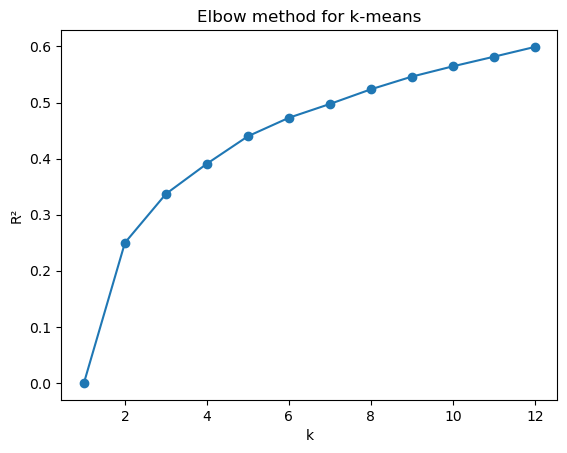

k=2, silhouette score=0.249
k=3, silhouette score=0.201
k=4, silhouette score=0.209
k=5, silhouette score=0.209
k=6, silhouette score=0.189
k=7, silhouette score=0.157
k=8, silhouette score=0.157
k=9, silhouette score=0.162
k=10, silhouette score=0.161
k=11, silhouette score=0.166
k=12, silhouette score=0.168


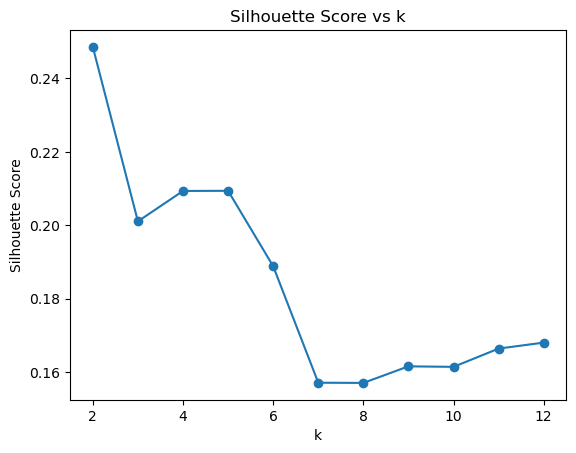

In [34]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

df = data_by_state.copy()

# === Stage 1: Ion & TDS Processing ===
# Define which columns are cations, anions, etc.
cations = ['Ca_mgL', 'Mg_mgL', 'Na_mgL', 'K_mgL']  # replace with your actual columns
anions = ['Cl_mgL', 'SO4_mgL']         # replace with your actual columns
silica_col = 'Si_mgL'
dissolved_solids_col = 'TDS_mgL'

# Molar masses (g/mol) for conversions
molar_masses = {
    'Ca_mgL': 40.078,
    'Mg_mgL': 24.305,
    'Na_mgL': 22.990,
    'K_mgL': 39.098,
    'Cl_mgL': 35.45,
    'SO4_mgL': 96.06,  # SO4-2
    'HCO3_mgl': 61.0168,
    silica_col: 60.08  # SiO2
}

# Charges for equivalent calculations
charges = {
    'Ca_mgL': 2,
    'Mg_mgL': 2,
    'Na_mgL': 1,
    'K_mgL': 1,
    'Cl_mgL': 1,
    'SO4_mgL': 2,
    'HCO3_mgl': 1
}

# Convert mg/L to equivalents for major ions
for ion in cations + anions:
    eq_col = ion + '_eq'
    df[eq_col] = (df[ion] / molar_masses[ion]) * charges[ion]

# Totals
df['total_cations_eq'] = df[[c + '_eq' for c in cations]].sum(axis=1)
df['total_anions_eq']  = df[[a + '_eq' for a in anions]].sum(axis=1)

# Fractions
for ion in cations:
    df[ion + '_frac'] = df[ion + '_eq'] / df['total_cations_eq']
for ion in anions:
    df[ion + '_frac'] = df[ion + '_eq'] / df['total_anions_eq']

# Print just the new columns created
#new_cols = [ion + '_eq' for ion in cations + anions] + ['total_cations_eq', 'total_anions_eq']
#print(df[new_cols].head())

# Silica fraction
df['Si_molL'] = df[silica_col] / molar_masses[silica_col]
df['total_ion_molL'] = (
    df[[ion + '_eq' for ion in cations + anions]]
    .div([charges[i] for i in cations + anions], axis=1)
    .sum(axis=1)
)
df['Si_molL_frac'] = df['Si_molL'] / df['total_ion_molL']

# Log transform TDS
df['TDS_log10'] = np.log10(df[dissolved_solids_col])

df = df[(df['model_C_molL'] > 0) & (df['model_C_molL'].notna())]

df['model_C_log10'] = np.log10(df['model_C_molL'])



# === Stage 2: Data Normalization ===
# Prepare dataframe for clustering
untouched = ['ph', 'Temp_C']
features = [col for col in df.columns if col.endswith('_frac')] + ['TDS_log10', 'model_C_log10'] + untouched
X = df[features]
print("Features used for clustering:", X.columns.tolist())

# Count NaNs in each column
print(df[features].isna().sum())

# Count number of NaN values
num_nan = df['model_C_molL'].isna().sum()

# Count number of zero values (excluding NaNs)
num_zero = (df['model_C_molL'] == 0).sum()

print(f"Number of NaN values in model_C_molL: {num_nan}")
print(f"Number of zero values in model_C_molL: {num_zero}")

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# R² vs k
K_range = range(1, 13)
r2_values = []
tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    between_ss = tot_ss - km.inertia_
    r2_values.append(between_ss / tot_ss)

plt.plot(K_range, r2_values, marker='o')
plt.xlabel('k')
plt.ylabel('R²')
plt.title('Elbow method for k-means')
plt.show()

# Final k=4 (example)
k_optimal = 4
km_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['Cluster'] = km_final.fit_predict(X_scaled)

# Save results
#df.to_csv("geochem_clusters_with_metadata.csv", index=False)

sil_scores = []
K_range = range(2, 13)  # silhouette score not defined for k=1

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    sil_scores.append(score)
    print(f"k={k}, silhouette score={score:.3f}")

# Plot the silhouette scores
plt.figure()
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()



In [35]:
k_optimal = 4  # Found via elbow method and same as what USGS found
km_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['Cluster'] = km_final.fit_predict(X_scaled)

print(df['Cluster'].value_counts())

cluster_means = pd.DataFrame(
    km_final.cluster_centers_, columns=X.columns
)
print(cluster_means)


Cluster
0    1569
3    1561
1    1260
2     414
Name: count, dtype: int64
   Ca_mgL_frac  Mg_mgL_frac  Na_mgL_frac  K_mgL_frac  Cl_mgL_frac  \
0     0.275839     0.331531    -0.343728    0.233842     0.565364   
1     1.045995     0.915230    -1.110080   -0.212203    -1.228956   
2    -0.684931    -0.286957     0.606912   -0.084447     0.600811   
3    -0.939900    -0.995876     1.080556   -0.041359     0.264377   

   SO4_mgL_frac  Si_molL_frac  TDS_log10  model_C_log10        ph    Temp_C  
0     -0.565364      0.140945  -0.231401       0.101714 -0.491988 -0.124543  
1      1.228956      0.177255  -0.132977      -0.158264 -0.363755 -0.571995  
2     -0.600811     -0.720023   2.364893      -0.290573 -0.256454  0.121742  
3     -0.264377     -0.093783  -0.287282       0.102576  0.856138  0.554593  


        Ca_mgL_frac           Mg_mgL_frac           Na_mgL_frac            \
               mean       std        mean       std        mean       std   
Cluster                                                                     
0          0.300075  0.132160    0.185365  0.084776    0.502613  0.152916   
1          0.456725  0.167869    0.255549  0.101992    0.281712  0.166643   
2          0.104653  0.086644    0.110998  0.077831    0.776635  0.130940   
3          0.052792  0.060575    0.025758  0.035436    0.913162  0.087439   

        K_mgL_frac           Cl_mgL_frac            ... Si_molL_frac  \
              mean       std        mean       std  ...         mean   
Cluster                                             ...                
0         0.011948  0.019831    0.726298  0.154935  ...     0.013727   
1         0.006014  0.006207    0.209449  0.142173  ...     0.014237   
2         0.007714  0.009225    0.736508  0.241869  ...     0.001640   
3         0.008287  0.008896

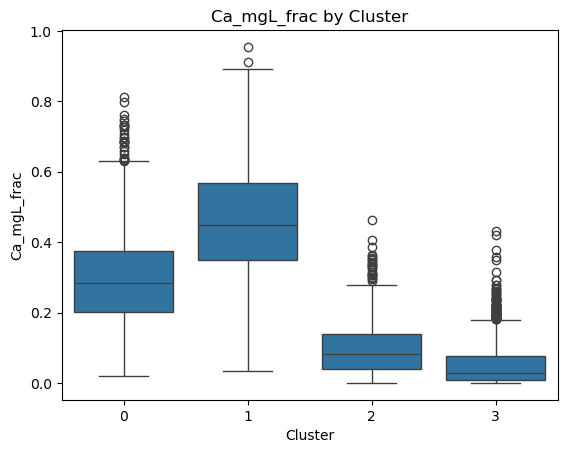

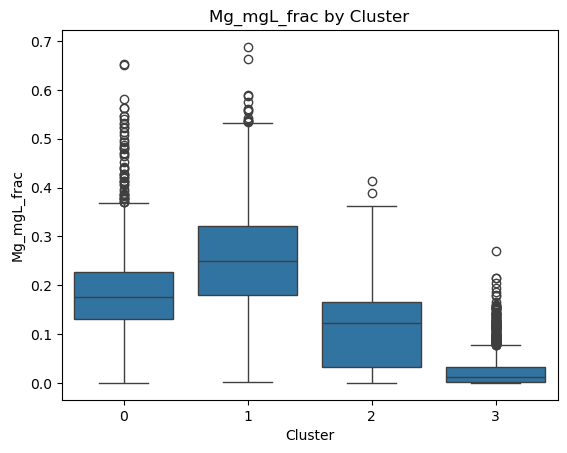

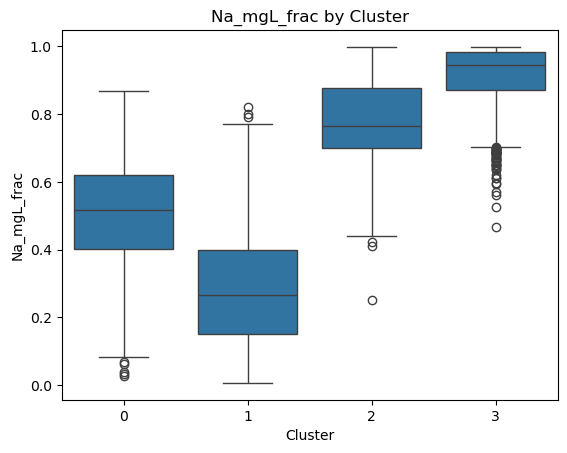

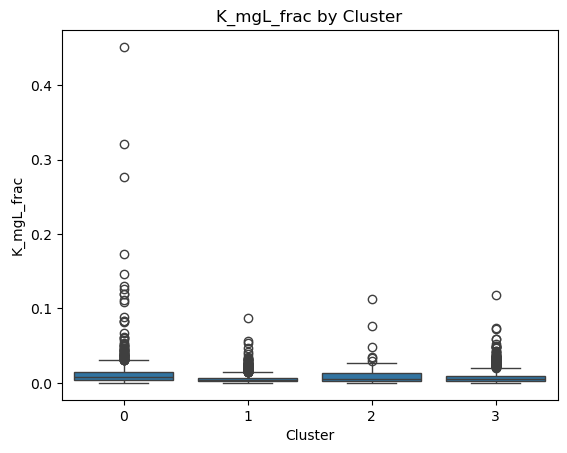

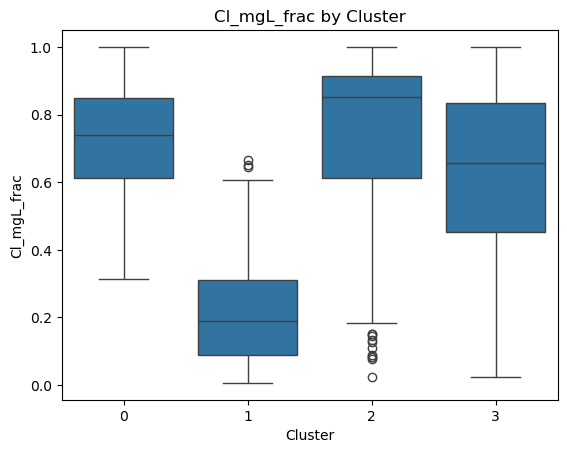

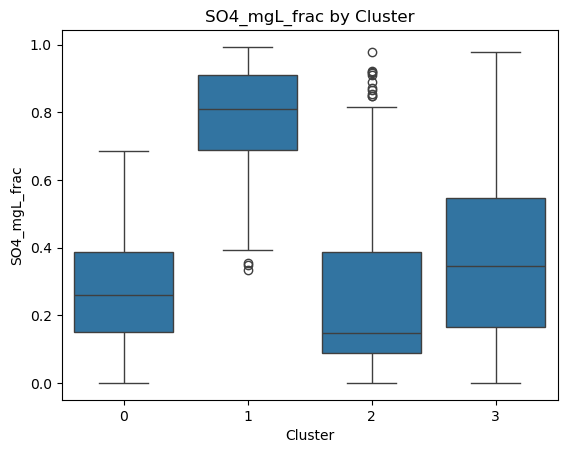

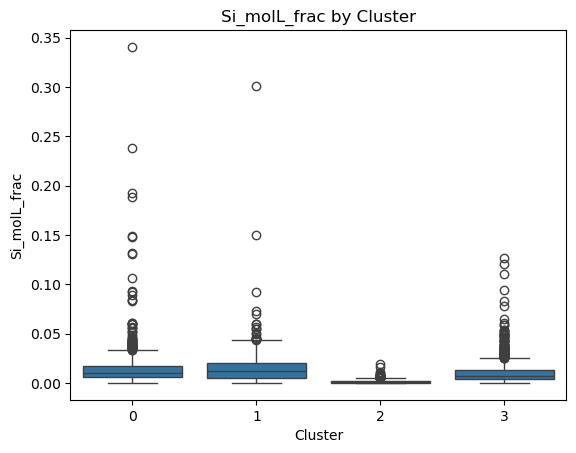

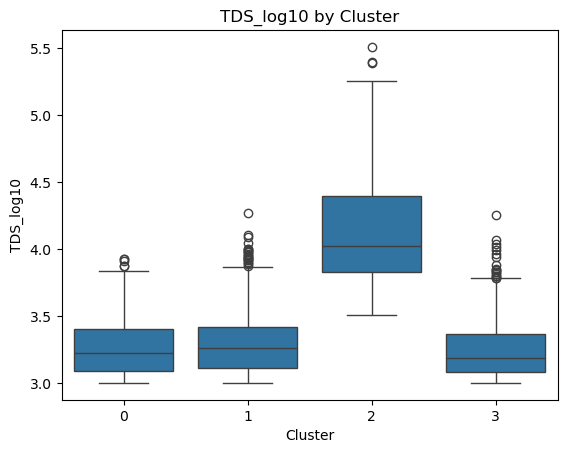

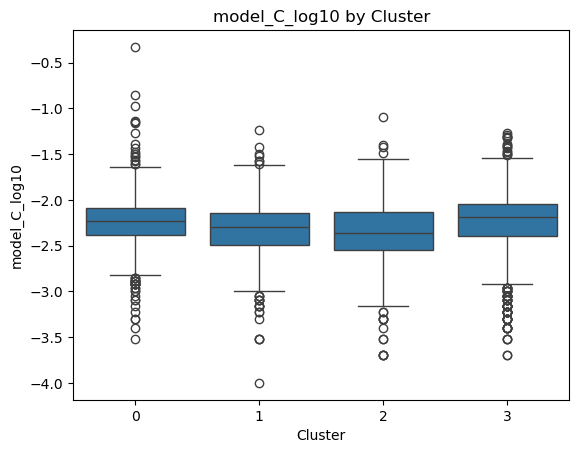

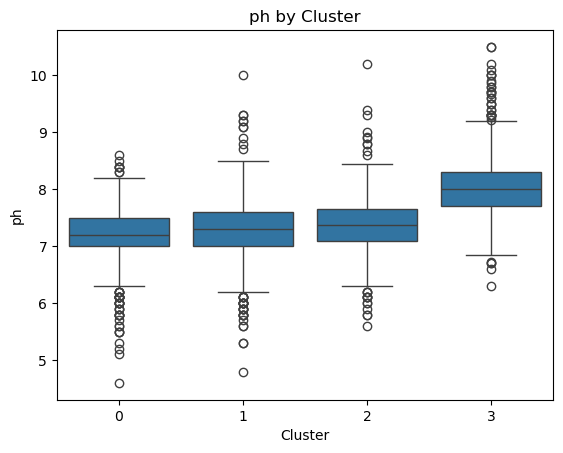

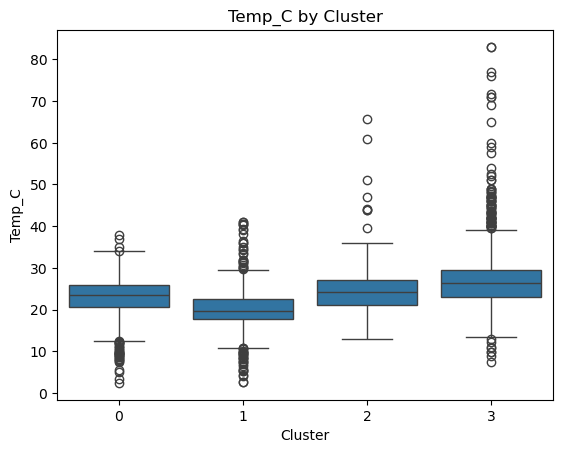

In [36]:
import seaborn as sns
# Attach cluster labels to your original df
df['Cluster'] = km_final.labels_

# Calculate means (and std) for each cluster
cluster_profile = df.groupby('Cluster')[features].agg(['mean', 'std'])

print(cluster_profile)


for feature in features:
    plt.figure()
    sns.boxplot(data=df, x='Cluster', y=feature)
    plt.title(f'{feature} by Cluster')
    plt.show()


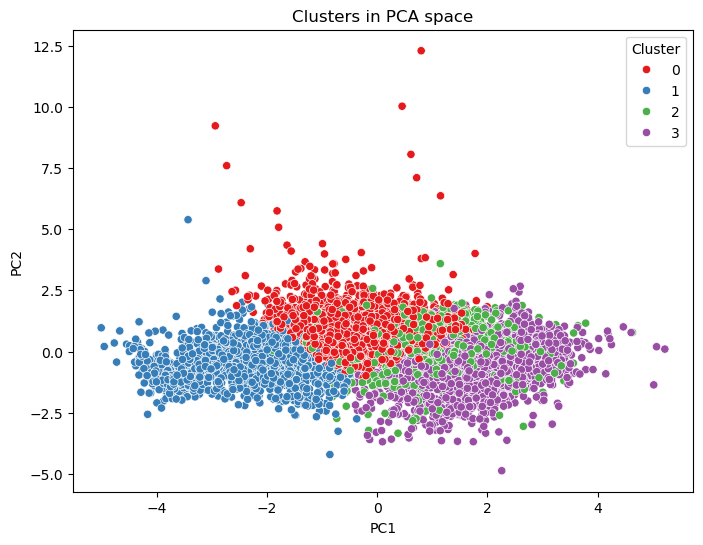

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='Set1')
plt.title('Clusters in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()



State: NM, Shape: (163, 11)


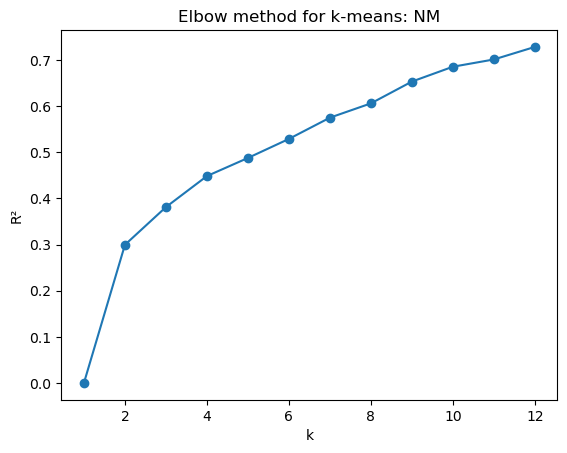

State=NM, k=2, silhouette score=0.325
State=NM, k=3, silhouette score=0.309
State=NM, k=4, silhouette score=0.343
State=NM, k=5, silhouette score=0.322
State=NM, k=6, silhouette score=0.239
State=NM, k=7, silhouette score=0.265
State=NM, k=8, silhouette score=0.341
State=NM, k=9, silhouette score=0.315
State=NM, k=10, silhouette score=0.358
State=NM, k=11, silhouette score=0.297
State=NM, k=12, silhouette score=0.286


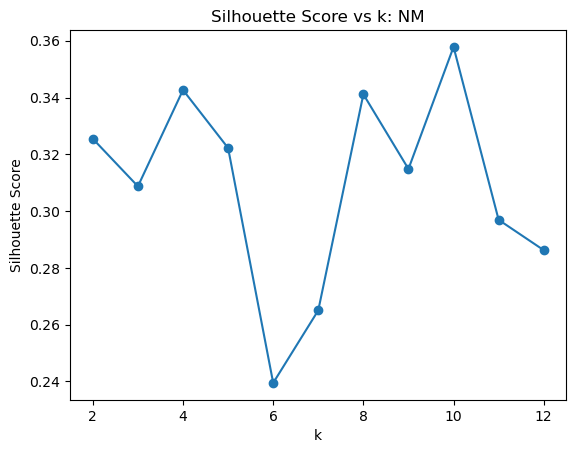

  Saved representative compositions for NM to NM_representative_compositions.csv

State: TX, Shape: (2384, 11)


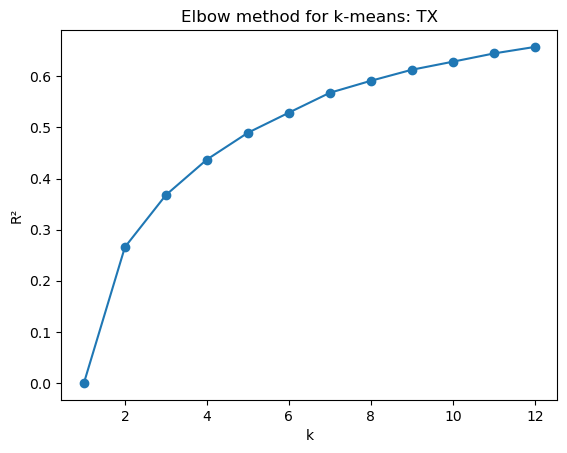

State=TX, k=2, silhouette score=0.283
State=TX, k=3, silhouette score=0.259
State=TX, k=4, silhouette score=0.256
State=TX, k=5, silhouette score=0.209
State=TX, k=6, silhouette score=0.211
State=TX, k=7, silhouette score=0.214
State=TX, k=8, silhouette score=0.188
State=TX, k=9, silhouette score=0.191
State=TX, k=10, silhouette score=0.187
State=TX, k=11, silhouette score=0.179
State=TX, k=12, silhouette score=0.180


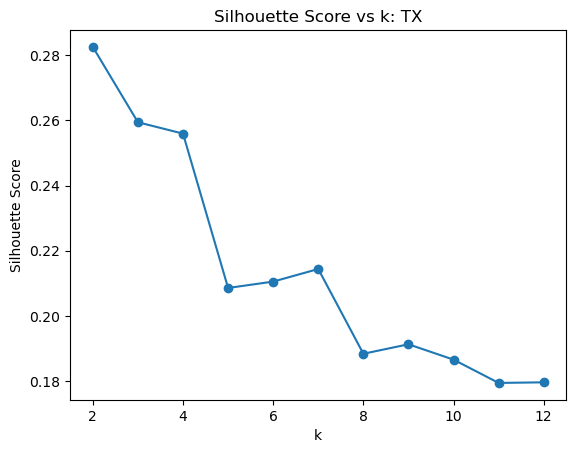

  Saved representative compositions for TX to TX_representative_compositions.csv

State: FL, Shape: (385, 11)


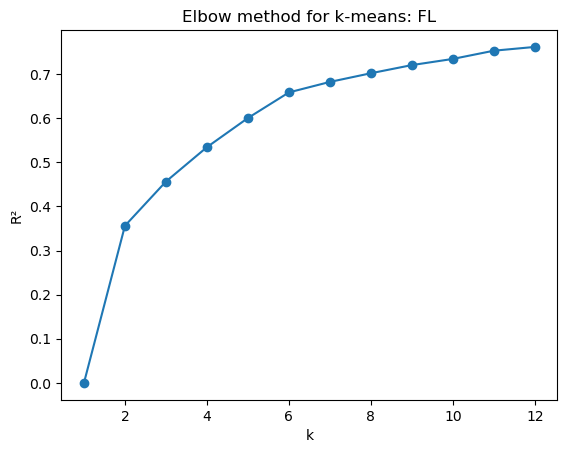

State=FL, k=2, silhouette score=0.453
State=FL, k=3, silhouette score=0.267
State=FL, k=4, silhouette score=0.303
State=FL, k=5, silhouette score=0.311
State=FL, k=6, silhouette score=0.322
State=FL, k=7, silhouette score=0.262
State=FL, k=8, silhouette score=0.279
State=FL, k=9, silhouette score=0.265
State=FL, k=10, silhouette score=0.234
State=FL, k=11, silhouette score=0.234
State=FL, k=12, silhouette score=0.226


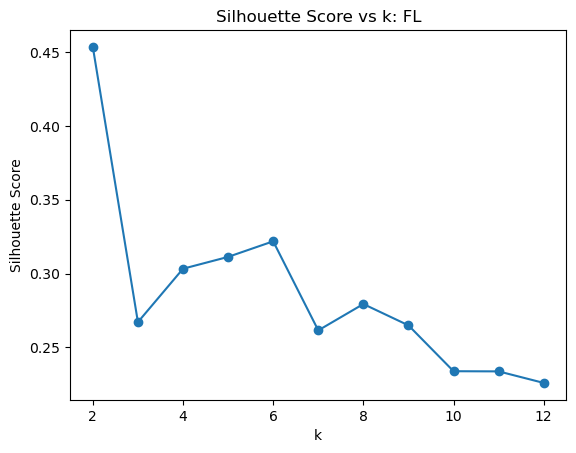

  Saved representative compositions for FL to FL_representative_compositions.csv

State: CA, Shape: (1267, 11)


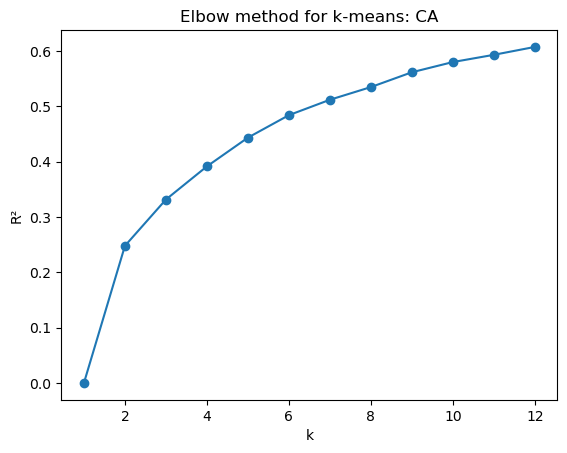

State=CA, k=2, silhouette score=0.258
State=CA, k=3, silhouette score=0.235
State=CA, k=4, silhouette score=0.186
State=CA, k=5, silhouette score=0.190
State=CA, k=6, silhouette score=0.186
State=CA, k=7, silhouette score=0.177
State=CA, k=8, silhouette score=0.164
State=CA, k=9, silhouette score=0.165
State=CA, k=10, silhouette score=0.171
State=CA, k=11, silhouette score=0.169
State=CA, k=12, silhouette score=0.150


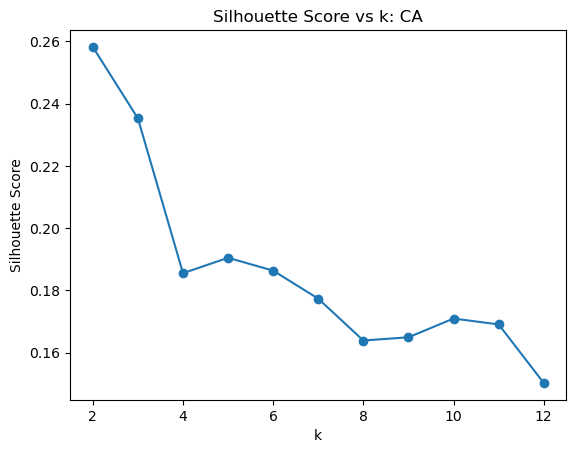

  Saved representative compositions for CA to CA_representative_compositions.csv

State: AZ, Shape: (605, 11)


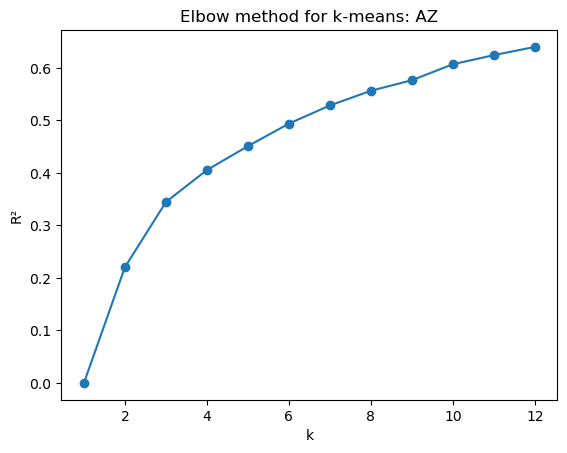

State=AZ, k=2, silhouette score=0.284
State=AZ, k=3, silhouette score=0.229
State=AZ, k=4, silhouette score=0.182
State=AZ, k=5, silhouette score=0.179
State=AZ, k=6, silhouette score=0.188
State=AZ, k=7, silhouette score=0.185
State=AZ, k=8, silhouette score=0.191
State=AZ, k=9, silhouette score=0.200
State=AZ, k=10, silhouette score=0.185
State=AZ, k=11, silhouette score=0.190
State=AZ, k=12, silhouette score=0.174


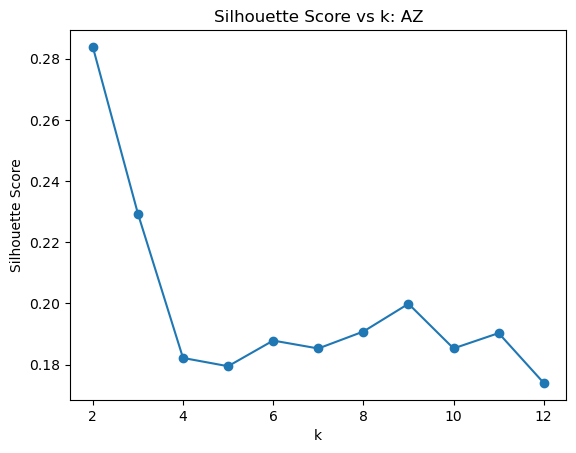

  Saved representative compositions for AZ to AZ_representative_compositions.csv


In [38]:
states = df['state_alpha'].unique()  # or adjust to match your state column

for state in states:
    X_state = X[df['state_alpha'] == state]
    print(f"\nState: {state}, Shape: {X_state.shape}")
    # Standardize per state
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_state)
    # Elbowe
    r2_values = []
    tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)
    k_max = min(12, len(X) - 1)  # Prevent k > n_samples
    elbow_k_range = range(1, k_max+1)
    for k in elbow_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X_scaled)
        between_ss = tot_ss - km.inertia_
        r2_values.append(between_ss / tot_ss)

    plt.figure()
    plt.plot(list(elbow_k_range), r2_values, marker='o')
    plt.xlabel('k')
    plt.ylabel('R²')
    plt.title(f'Elbow method for k-means: {state}')
    plt.show()

    # Silhouett
    sil_scores = []
    sil_k_range = range(2, min(13, len(X)))  # Need at least 2 samples per cluster
    for k in sil_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        print(f"State={state}, k={k}, silhouette score={score:.3f}")

    plt.figure()
    plt.plot(list(sil_k_range), sil_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs k: {state}')
    plt.show()

    state_clean = str(state).replace(" ","_")
    csv_path = os.path.join(f"{state_clean}_representative_compositions.csv")
    cluster_means.to_csv(csv_path, index=False)
    print(f"  Saved representative compositions for {state} to {csv_path}")



In [39]:
state_k_map = {
    "NM": 4,
    "TX": 4,
    "FL": 6,
    "CA": 5,
    "AZ": 6
}

results = {}
output_folder = "boxplots"
# FIRST LOOP: Cluster per state and collect results
for state, k_opt in state_k_map.items():
    print(f"\n--- Analyzing {state} (k={k_opt}) ---")
    df_state = df[df['state_alpha'] == state].copy()
    X_state = df_state[features]
    
    # Ensure clean data
    X_state = X_state.replace([np.inf, -np.inf], np.nan).dropna()
    df_state = df_state.loc[X_state.index]
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_state)

    # Perform k-means
    km = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
    df_state['Cluster'] = km.fit_predict(X_scaled)

    # (Optional) Show cluster sizes and means for this state
    print(df_state['Cluster'].value_counts())
    print(df_state.groupby('Cluster')[features].mean())

    # Save or store result for later use
    results[state] = df_state
    # df_state.to_csv(f"geochem_clusters_{state}.csv", index=False)



# SECOND LOOP: Generate and save summary boxplots per state

for state, df_state in results.items():
    n_features = len(features)
    n_cols = 3  # Adjust as needed for aesthetics
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax = axes[idx]
        sns.boxplot(x='Cluster', y=feature, data=df_state, ax=ax)
        ax.set_title(f"{feature} by Cluster in {state}")
    # Hide any unused axes
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    # Save in boxplots folder
    plt.savefig(os.path.join(output_folder, f"Cluster_Boxplots_{state}.png"), dpi=300)
    plt.close(fig)  # Free memory

    print(f"{state} saved as Cluster_Boxplots_{state}.png")



--- Analyzing NM (k=4) ---
Cluster
1    97
3    24
2    22
0    20
Name: count, dtype: int64
         Ca_mgL_frac  Mg_mgL_frac  Na_mgL_frac  K_mgL_frac  Cl_mgL_frac  \
Cluster                                                                   
0           0.035310     0.019991     0.940239    0.004460     0.576036   
1           0.452587     0.164523     0.372184    0.010706     0.276584   
2           0.241471     0.089937     0.661240    0.007352     0.761459   
3           0.204392     0.072882     0.681859    0.040867     0.663605   

         SO4_mgL_frac  Si_molL_frac  TDS_log10  model_C_log10        ph  \
Cluster                                                                   
0            0.423964      0.005918   3.459473      -2.092357  8.196000   
1            0.723416      0.016949   3.207890      -2.181653  7.286495   
2            0.238541      0.002099   4.014800      -3.096641  7.565000   
3            0.336395      0.020380   3.335985      -2.220362  7.570000   

    

Cluster
2    1233
0     781
1     358
3      12
Name: count, dtype: int64
         Ca_mgL_frac  Mg_mgL_frac  Na_mgL_frac  K_mgL_frac  Cl_mgL_frac  \
Cluster                                                                   
0           0.333748     0.200546     0.453689    0.012017     0.714793   
1           0.592504     0.234679     0.168114    0.004703     0.159873   
2           0.037201     0.019524     0.935006    0.008269     0.658335   
3           0.480169     0.075648     0.304621    0.139562     0.656887   

         SO4_mgL_frac  Si_molL_frac  TDS_log10  model_C_log10        ph  \
Cluster                                                                   
0            0.285207      0.012371   3.269427      -2.171500  7.066428   
1            0.840127      0.005463   3.335182      -2.372827  7.150000   
2            0.341665      0.008786   3.287650      -2.185955  7.949392   
3            0.343113      0.156907   3.415799      -2.517224  6.930000   

            Temp_C  
Clu

In [40]:
from sklearn.decomposition import PCA
for state, df_state in results.items():
    # Extract features and standardize, as used in clustering
    X_state = df_state[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_state)

    # PCA transformation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_state['Cluster'], palette='Set1', s=30)
    plt.title(f'Clusters in PCA space: {state}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.savefig(f"PCA_Clusters_{state}.png", dpi=300)
    plt.close()

    print(f"{state} PCA plot saved as PCA_Clusters_{state}.png")

"""
# Print PCA loadings as a DataFrame
loadings = pd.DataFrame(
    pca.components_.T,  # transpose so rows = features, columns = PCs
    columns=['PC1', 'PC2'],
    index=features      # features in your clustering
)
print(loadings)
"""

NM PCA plot saved as PCA_Clusters_NM.png
TX PCA plot saved as PCA_Clusters_TX.png
FL PCA plot saved as PCA_Clusters_FL.png
CA PCA plot saved as PCA_Clusters_CA.png
AZ PCA plot saved as PCA_Clusters_AZ.png


"\n# Print PCA loadings as a DataFrame\nloadings = pd.DataFrame(\n    pca.components_.T,  # transpose so rows = features, columns = PCs\n    columns=['PC1', 'PC2'],\n    index=features      # features in your clustering\n)\nprint(loadings)\n"

=== CLUSTERING ACROSS ALL STATES ===


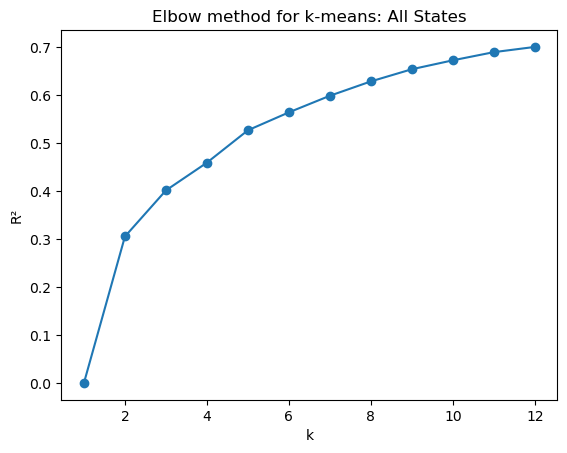

All States, k=2, silhouette score=0.317
All States, k=3, silhouette score=0.251
All States, k=4, silhouette score=0.228
All States, k=5, silhouette score=0.234
All States, k=6, silhouette score=0.231
All States, k=7, silhouette score=0.231
All States, k=8, silhouette score=0.215
All States, k=9, silhouette score=0.214
All States, k=10, silhouette score=0.201
All States, k=11, silhouette score=0.204
All States, k=12, silhouette score=0.203


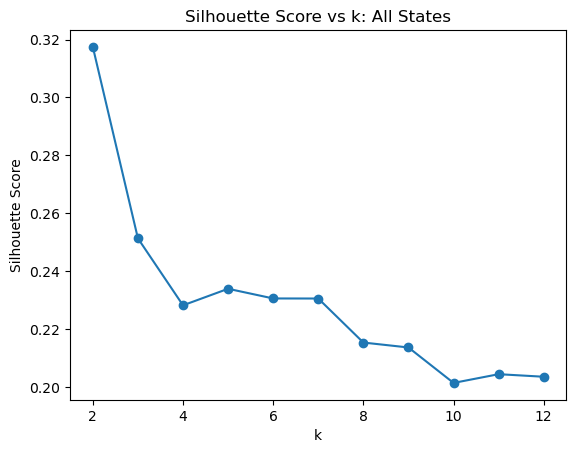

Boxplots saved at: ion/Boxplots_by_Cluster_AllStates.png
PCA plot saved at: ion/PCA_Clusters_AllStates.png


In [41]:
########## ION CLUSTERING ##########

ion_cols = [col for col in df.columns if col.endswith('_frac')] + ['model_C_log10']
state_col = 'state_alpha'  # or whatever column contains state labels

# 1. Clustering across all states together
print("=== CLUSTERING ACROSS ALL STATES ===")
df_ions = df[ion_cols].copy()
df_ions = df_ions.replace([np.inf, -np.inf], np.nan).dropna()

# Standardization
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(df_ions)

# Elbow method (R²)
r2_values = []
k_max = min(12, len(X_scaled_all) - 1)
elbow_k_range = range(1, k_max+1)
tot_ss = np.sum((X_scaled_all - X_scaled_all.mean(axis=0)) ** 2)
for k in elbow_k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled_all)
    between_ss = tot_ss - km.inertia_
    r2_values.append(between_ss / tot_ss)

plt.figure()
plt.plot(list(elbow_k_range), r2_values, marker='o')
plt.xlabel('k')
plt.ylabel('R²')
plt.title('Elbow method for k-means: All States')
plt.show()

# Silhouette method
sil_scores = []
sil_k_range = range(2, min(13, len(X_scaled_all)))
for k in sil_k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_all)
    score = silhouette_score(X_scaled_all, labels)
    sil_scores.append(score)
    print(f"All States, k={k}, silhouette score={score:.3f}")

plt.figure()
plt.plot(list(sil_k_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k: All States')
plt.show()


########## CLUSTER ASSIGNMENT FOR ALL STATES ##########

k_general = 5
km = KMeans(n_clusters=k_general, random_state=42, n_init=10)
cluster_labels = km.fit_predict(X_scaled_all)

# Add cluster labels to DataFrame for easy plotting
df_plot = df_ions.copy()
df_plot['Cluster'] = cluster_labels.astype(str)  # String for plotting labels

# 1. BOX PLOTS FOR EACH ION FEATURE BY CLUSTER
output_folder = "ion"
n_features = len(ion_cols)
n_cols = 3  
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, feature in enumerate(ion_cols):
    ax = axes[idx]
    sns.boxplot(x='Cluster', y=feature, data=df_plot, ax=ax)
    ax.set_title(f"{feature} by Cluster")
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "Boxplots_by_Cluster_AllStates.png"), dpi=300)
plt.close(fig)
print("Boxplots saved at:", os.path.join(output_folder, "Boxplots_by_Cluster_AllStates.png"))

# 2. PCA SCATTER PLOT

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_all)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_plot['Cluster'], palette='Set1', s=30)
plt.title('PCA of Clusters (All States)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "PCA_Clusters_AllStates.png"), dpi=300)
plt.close()
print("PCA plot saved at:", os.path.join(output_folder, "PCA_Clusters_AllStates.png"))






State: NM, Shape: (163, 8)


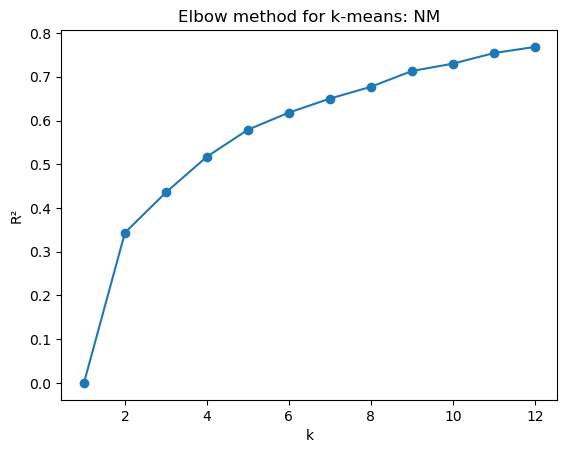

State=NM, k=2, silhouette score=0.362
State=NM, k=3, silhouette score=0.342
State=NM, k=4, silhouette score=0.378
State=NM, k=5, silhouette score=0.296
State=NM, k=6, silhouette score=0.310
State=NM, k=7, silhouette score=0.359
State=NM, k=8, silhouette score=0.327
State=NM, k=9, silhouette score=0.304
State=NM, k=10, silhouette score=0.274
State=NM, k=11, silhouette score=0.316
State=NM, k=12, silhouette score=0.242


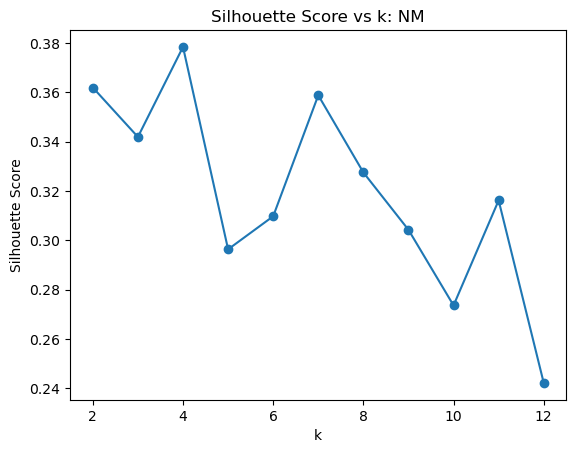


State: TX, Shape: (2384, 8)


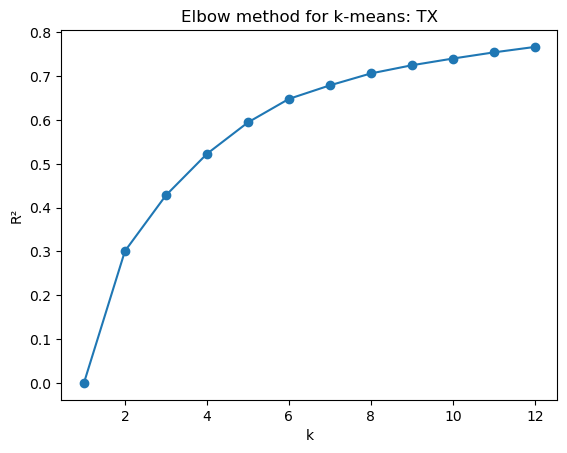

State=TX, k=2, silhouette score=0.351
State=TX, k=3, silhouette score=0.329
State=TX, k=4, silhouette score=0.326
State=TX, k=5, silhouette score=0.289
State=TX, k=6, silhouette score=0.291
State=TX, k=7, silhouette score=0.280
State=TX, k=8, silhouette score=0.262
State=TX, k=9, silhouette score=0.266
State=TX, k=10, silhouette score=0.247
State=TX, k=11, silhouette score=0.245
State=TX, k=12, silhouette score=0.236


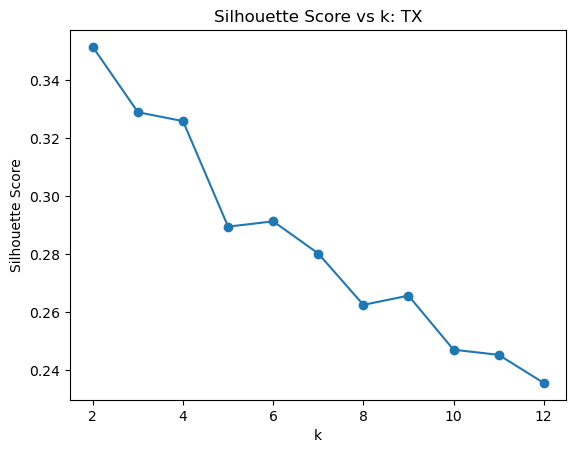


State: FL, Shape: (385, 8)


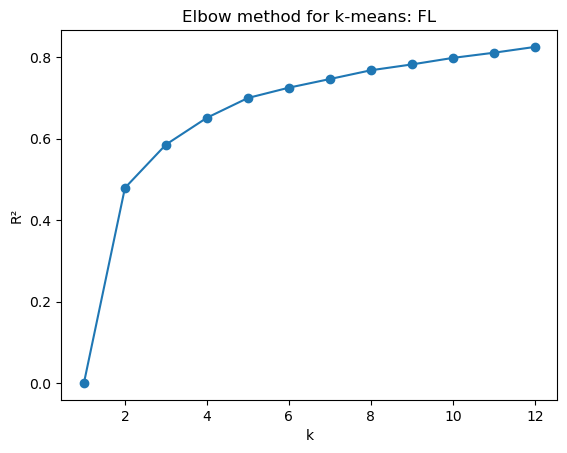

State=FL, k=2, silhouette score=0.566
State=FL, k=3, silhouette score=0.584
State=FL, k=4, silhouette score=0.351
State=FL, k=5, silhouette score=0.300
State=FL, k=6, silhouette score=0.305
State=FL, k=7, silhouette score=0.304
State=FL, k=8, silhouette score=0.279
State=FL, k=9, silhouette score=0.232
State=FL, k=10, silhouette score=0.283
State=FL, k=11, silhouette score=0.243
State=FL, k=12, silhouette score=0.268


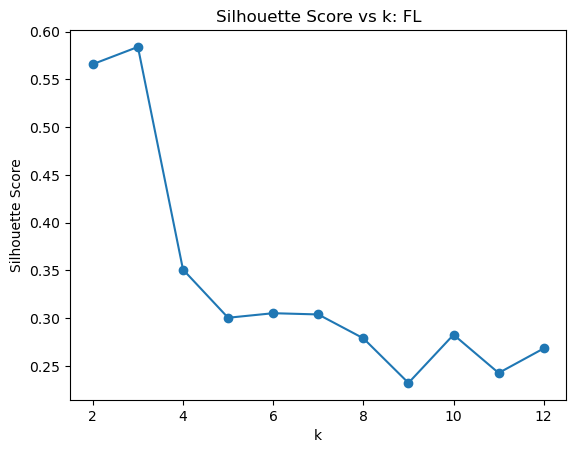


State: CA, Shape: (1267, 8)


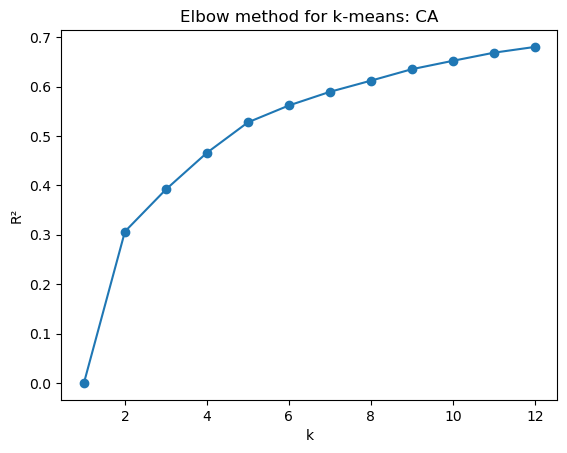

State=CA, k=2, silhouette score=0.299
State=CA, k=3, silhouette score=0.228
State=CA, k=4, silhouette score=0.249
State=CA, k=5, silhouette score=0.228
State=CA, k=6, silhouette score=0.231
State=CA, k=7, silhouette score=0.195
State=CA, k=8, silhouette score=0.186
State=CA, k=9, silhouette score=0.187
State=CA, k=10, silhouette score=0.184
State=CA, k=11, silhouette score=0.184
State=CA, k=12, silhouette score=0.183


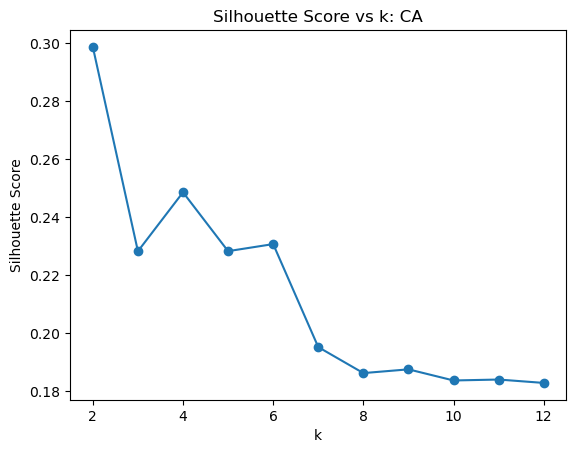


State: AZ, Shape: (605, 8)


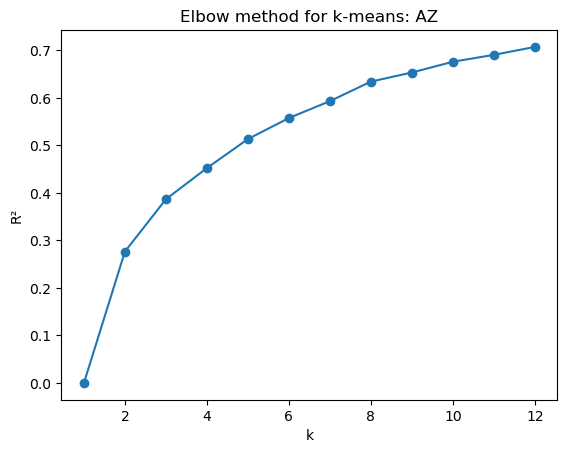

State=AZ, k=2, silhouette score=0.368
State=AZ, k=3, silhouette score=0.233
State=AZ, k=4, silhouette score=0.245
State=AZ, k=5, silhouette score=0.247
State=AZ, k=6, silhouette score=0.247
State=AZ, k=7, silhouette score=0.209
State=AZ, k=8, silhouette score=0.225
State=AZ, k=9, silhouette score=0.232
State=AZ, k=10, silhouette score=0.230
State=AZ, k=11, silhouette score=0.216
State=AZ, k=12, silhouette score=0.218


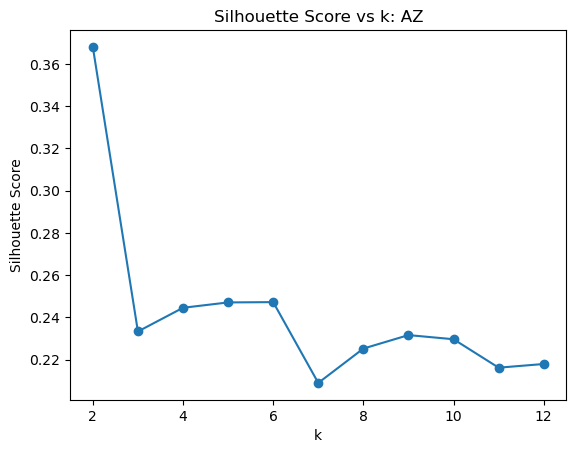

In [42]:
########## ION CLUSTERING BY STATE PART 1 ##########


for state in states:
    X_state = X_scaled_all[df['state_alpha'] == state]
    print(f"\nState: {state}, Shape: {X_state.shape}")
    # Standardize per state
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_state)
    # Elbow
    r2_values = []
    tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)
    k_max = min(12, len(X) - 1)  # Prevent k > n_samples
    elbow_k_range = range(1, k_max+1)
    for k in elbow_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X_scaled)
        between_ss = tot_ss - km.inertia_
        r2_values.append(between_ss / tot_ss)

    plt.figure()
    plt.plot(list(elbow_k_range), r2_values, marker='o')
    plt.xlabel('k')
    plt.ylabel('R²')
    plt.title(f'Elbow method for k-means: {state}')
    plt.show()

    # Silhouette
    sil_scores = []
    sil_k_range = range(2, min(13, len(X)))  # Need at least 2 samples per cluster
    for k in sil_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        print(f"State={state}, k={k}, silhouette score={score:.3f}")

    plt.figure()
    plt.plot(list(sil_k_range), sil_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs k: {state}')
    plt.show()




In [43]:
########## ION CLUSTERING BY STATE PART 1 ##########

state_k_map = {
    "NM": 4,
    "TX": 4,
    "FL": 4,
    "CA": 4,
    "AZ": 5
}

for state, k_state in state_k_map.items():
    df_state = df_ions[df['state_alpha'] == state].copy()
    X_scaled_state = X_scaled_all[df['state_alpha'] == state]

    # Cluster assignment
    km_state = KMeans(n_clusters=k_state, random_state=42, n_init=10)
    cluster_labels = km_state.fit_predict(X_scaled_state)
    df_plot_state = df_state.copy()
    df_plot_state['Cluster'] = cluster_labels.astype(str)
    
    # Boxplot grid
    n_features = len(ion_cols)
    n_cols = 3
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    for idx, feature in enumerate(ion_cols):
        ax = axes[idx]
        sns.boxplot(x='Cluster', y=feature, data=df_plot_state, ax=ax)
        ax.set_title(f"{feature} by Cluster")
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Boxplots_by_Cluster_{state}.png"), dpi=300)
    plt.close(fig)
    print(f"Boxplots saved at: {output_folder}/Boxplots_by_Cluster_{state}.png")

    # PCA plot
    pca = PCA(n_components=2)
    X_pca_state = pca.fit_transform(X_scaled_state)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca_state[:,0], y=X_pca_state[:,1], hue=df_plot_state['Cluster'], palette='Set1', s=30)
    plt.title(f'PCA of Clusters ({state})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"PCA_Clusters_{state}.png"), dpi=300)
    plt.close()
    print(f"PCA plot saved at: {output_folder}/PCA_Clusters_{state}.png")
    

Boxplots saved at: ion/Boxplots_by_Cluster_NM.png
PCA plot saved at: ion/PCA_Clusters_NM.png
Boxplots saved at: ion/Boxplots_by_Cluster_TX.png
PCA plot saved at: ion/PCA_Clusters_TX.png
Boxplots saved at: ion/Boxplots_by_Cluster_FL.png
PCA plot saved at: ion/PCA_Clusters_FL.png
Boxplots saved at: ion/Boxplots_by_Cluster_CA.png
PCA plot saved at: ion/PCA_Clusters_CA.png
Boxplots saved at: ion/Boxplots_by_Cluster_AZ.png
PCA plot saved at: ion/PCA_Clusters_AZ.png


In [44]:
############### ION + SI CLUSTERING ACROSS ALL STATES ###############

# Step 1: Update feature columns
si_cols = ['model_si_Calcite', 'model_si_Chalcedony', 'model_si_Gypsum', 'model_si_Barite']
ion_si_cols = ion_cols + si_cols

output_folder = "ion_si"

# Prepare data across all states
df_features = df[ion_si_cols].replace([np.inf, -np.inf], np.nan).dropna()
X_all = df_features.values
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)

# 1. Elbow method (R²)
r2_values = []
k_max = min(12, len(X_scaled_all) - 1)
elbow_k_range = range(1, k_max+1)
tot_ss = np.sum((X_scaled_all - X_scaled_all.mean(axis=0)) ** 2)
for k in elbow_k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled_all)
    between_ss = tot_ss - km.inertia_
    r2_values.append(between_ss / tot_ss)


plt.figure()
plt.plot(list(elbow_k_range), r2_values, marker='o')
plt.xlabel('k')
plt.ylabel('R²')
plt.title('Elbow method for k-means: All States (Ion+SI)')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "Elbow_AllStates.png"), dpi=300)
plt.close()

# 2. Silhouette method
sil_scores = []
sil_k_range = range(2, min(13, len(X_scaled_all)))
for k in sil_k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_all)
    score = silhouette_score(X_scaled_all, labels)
    sil_scores.append(score)
    print(f"All States (Ion+SI), k={k}, silhouette score={score:.3f}")

plt.figure()
plt.plot(list(sil_k_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k: All States (Ion+SI)')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "Silhouette_AllStates.png"), dpi=300)
plt.close()

k_use = 4

# 3. Final clustering and labeling for plotting
km = KMeans(n_clusters=k_use, random_state=42, n_init=10)
cluster_labels = km.fit_predict(X_scaled_all)
df_plot = df_features.copy()
df_plot['Cluster'] = cluster_labels.astype(str)

# 4. Multi-panel boxplots of ion+SI by cluster
n_features = len(ion_si_cols)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, feature in enumerate(ion_si_cols):
    ax = axes[idx]
    sns.boxplot(x='Cluster', y=feature, data=df_plot, ax=ax)
    ax.set_title(f"{feature} by Cluster")
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "Boxplots_by_Cluster_AllStates.png"), dpi=300)
plt.close(fig)
print("Boxplots saved at:", os.path.join(output_folder, "Boxplots_by_Cluster_AllStates.png"))

# 5. PCA scatterplot of clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_all)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_plot['Cluster'], palette='Set1', s=30)
plt.title('PCA of Clusters (All States, Ion+SI)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "PCA_Clusters_AllStates.png"), dpi=300)
plt.close()
print("PCA plot saved at:", os.path.join(output_folder, "PCA_Clusters_AllStates.png"))


All States (Ion+SI), k=2, silhouette score=0.239
All States (Ion+SI), k=3, silhouette score=0.199
All States (Ion+SI), k=4, silhouette score=0.198
All States (Ion+SI), k=5, silhouette score=0.188
All States (Ion+SI), k=6, silhouette score=0.178
All States (Ion+SI), k=7, silhouette score=0.174
All States (Ion+SI), k=8, silhouette score=0.182
All States (Ion+SI), k=9, silhouette score=0.176
All States (Ion+SI), k=10, silhouette score=0.171
All States (Ion+SI), k=11, silhouette score=0.159
All States (Ion+SI), k=12, silhouette score=0.153
Boxplots saved at: ion_si/Boxplots_by_Cluster_AllStates.png
PCA plot saved at: ion_si/PCA_Clusters_AllStates.png



--- State: NM, Shape: (97, 12) ---

--- State: NM ---


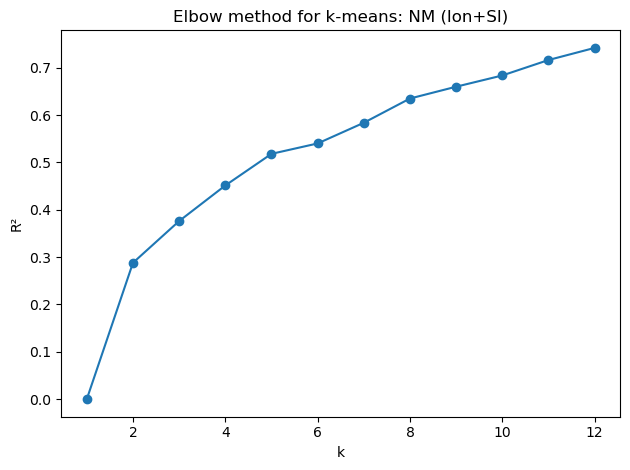

  k=2, silhouette score=0.364
  k=3, silhouette score=0.373
  k=4, silhouette score=0.378
  k=5, silhouette score=0.288
  k=6, silhouette score=0.206
  k=7, silhouette score=0.219
  k=8, silhouette score=0.334
  k=9, silhouette score=0.203
  k=10, silhouette score=0.286
  k=11, silhouette score=0.263
  k=12, silhouette score=0.343


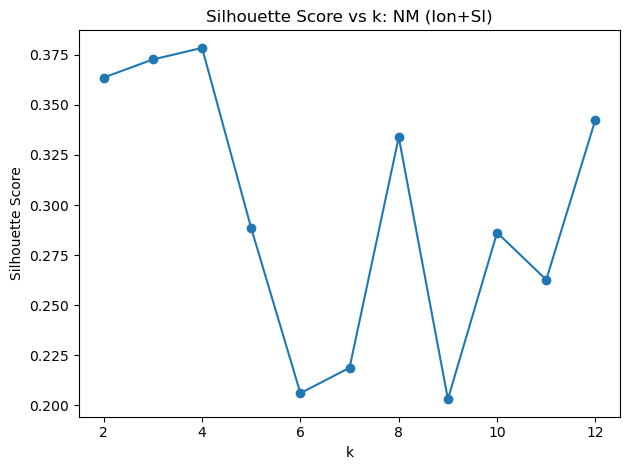


--- State: TX, Shape: (1836, 12) ---

--- State: TX ---


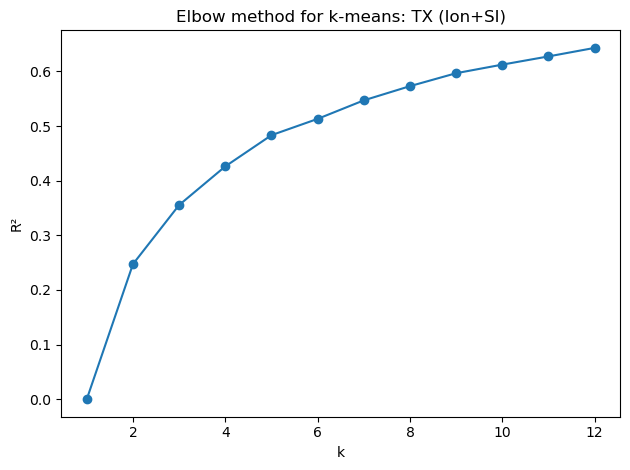

  k=2, silhouette score=0.258
  k=3, silhouette score=0.230
  k=4, silhouette score=0.229
  k=5, silhouette score=0.226
  k=6, silhouette score=0.198
  k=7, silhouette score=0.198
  k=8, silhouette score=0.196
  k=9, silhouette score=0.174
  k=10, silhouette score=0.171
  k=11, silhouette score=0.169
  k=12, silhouette score=0.171


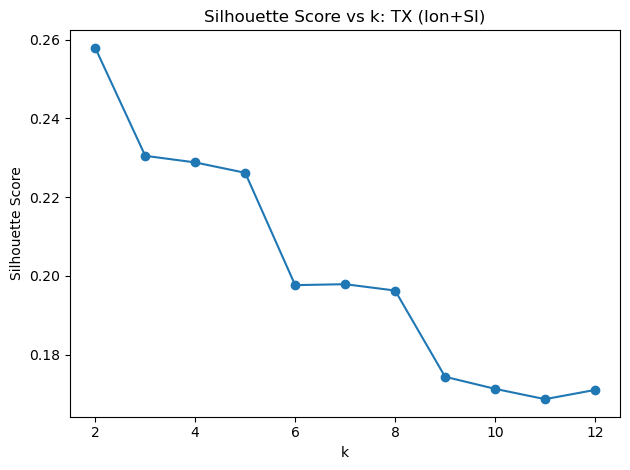


--- State: FL, Shape: (68, 12) ---

--- State: FL ---


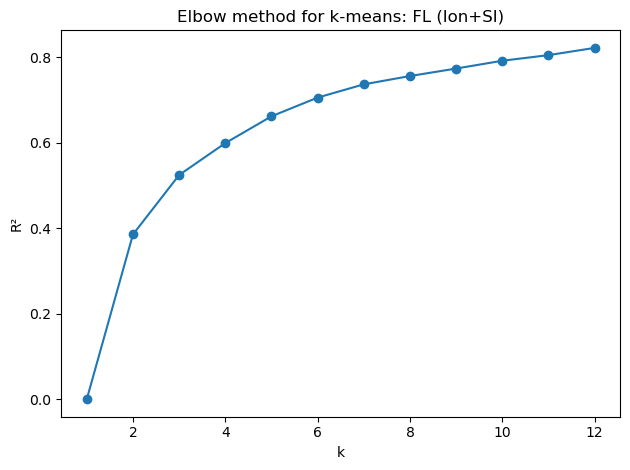

  k=2, silhouette score=0.415
  k=3, silhouette score=0.351
  k=4, silhouette score=0.331
  k=5, silhouette score=0.297
  k=6, silhouette score=0.298
  k=7, silhouette score=0.297
  k=8, silhouette score=0.270
  k=9, silhouette score=0.265
  k=10, silhouette score=0.266
  k=11, silhouette score=0.217
  k=12, silhouette score=0.224


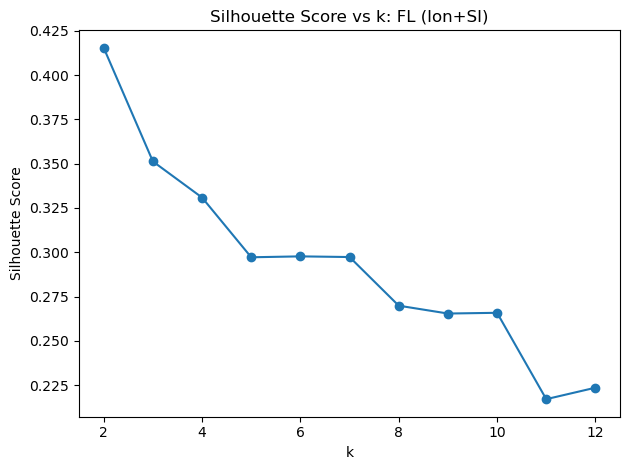


--- State: CA, Shape: (567, 12) ---

--- State: CA ---


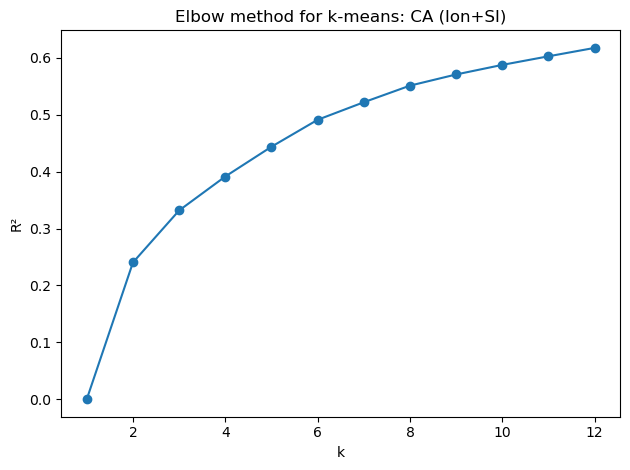

  k=2, silhouette score=0.245
  k=3, silhouette score=0.199
  k=4, silhouette score=0.203
  k=5, silhouette score=0.215
  k=6, silhouette score=0.215
  k=7, silhouette score=0.188
  k=8, silhouette score=0.193
  k=9, silhouette score=0.192
  k=10, silhouette score=0.183
  k=11, silhouette score=0.168
  k=12, silhouette score=0.181


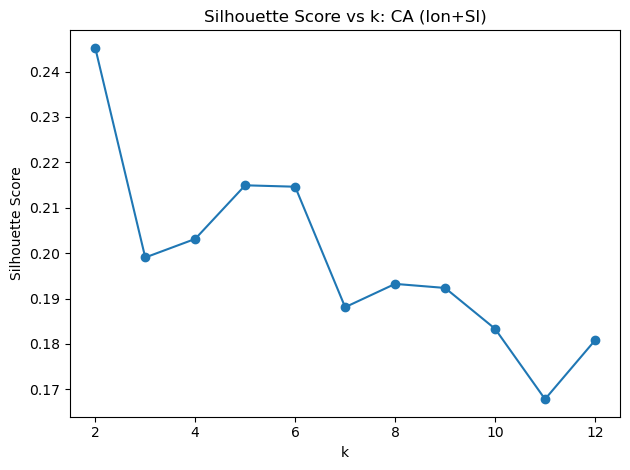


--- State: AZ, Shape: (266, 12) ---

--- State: AZ ---


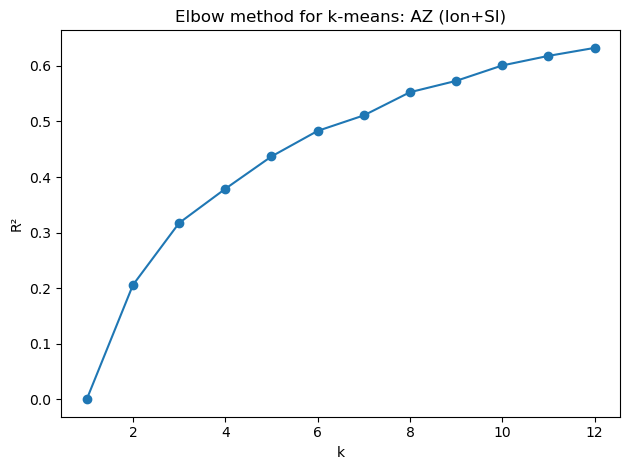

  k=2, silhouette score=0.207
  k=3, silhouette score=0.189
  k=4, silhouette score=0.156
  k=5, silhouette score=0.170
  k=6, silhouette score=0.168
  k=7, silhouette score=0.171
  k=8, silhouette score=0.192
  k=9, silhouette score=0.171
  k=10, silhouette score=0.181
  k=11, silhouette score=0.181
  k=12, silhouette score=0.178


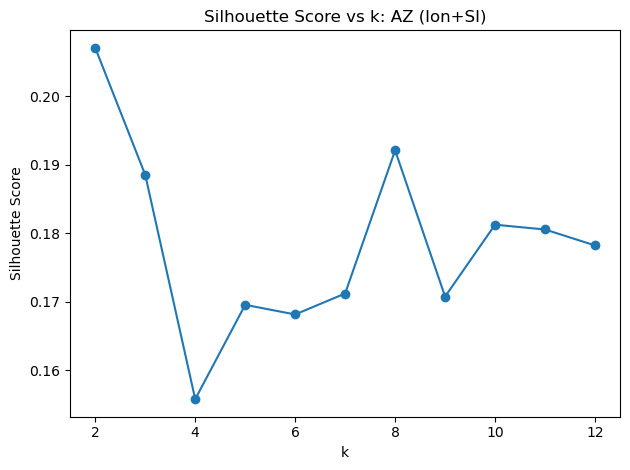

In [45]:
############### ION + SI CLUSTERING BY STATE PART 1 ###############

for state in states:
    # Prepare data for this state
    df_state = df[df[state_col] == state][ion_si_cols].replace([np.inf, -np.inf], np.nan).dropna()

    print(f"\n--- State: {state}, Shape: {df_state.shape} ---")

    print(f"\n--- State: {state} ---")
    if len(df_state) < 10:
        print(f"  Not enough samples, skipping.")
        continue

    X = df_state.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ----- 1. Elbow method (R²) -----
    r2_values = []
    k_max = min(12, len(X_scaled)-1)
    elbow_k_range = range(1, k_max+1)
    tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)
    for k in elbow_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X_scaled)
        between_ss = tot_ss - km.inertia_
        r2_values.append(between_ss / tot_ss)

    plt.figure()
    plt.plot(list(elbow_k_range), r2_values, marker='o')
    plt.xlabel('k')
    plt.ylabel('R²')
    plt.title(f'Elbow method for k-means: {state} (Ion+SI)')
    plt.tight_layout()
    plt.show()

    # ----- 2. Silhouette method -----
    sil_scores = []
    sil_k_range = range(2, min(13, len(X_scaled)))
    for k in sil_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        print(f"  k={k}, silhouette score={score:.3f}")

    plt.figure()
    plt.plot(list(sil_k_range), sil_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs k: {state} (Ion+SI)')
    plt.tight_layout()
    plt.show()




In [46]:
############### ION + SI CLUSTERING BY STATE PART 2 ###############

state_k_map = {
    'NM': 4,
    'TX': 5,
    'FL': 3,
    'CA': 5,
    'AZ': 3
}

for state, k_state in state_k_map.items():
    print(f"\n--- Processing {state} (k={k_state}) ---")
    df_state = df[df[state_col] == state][ion_si_cols].replace([np.inf, -np.inf], np.nan).dropna()
    if len(df_state) < k_state:
        print(f"  Not enough samples for k={k_state}, skipping.")
        continue
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_state)

    # Cluster assignment
    km = KMeans(n_clusters=k_state, random_state=42, n_init=10)
    cluster_labels = km.fit_predict(X_scaled)
    df_plot = df_state.copy()
    df_plot['Cluster'] = cluster_labels.astype(str)

    # Multi-panel boxplots of features by cluster
    n_features = len(ion_si_cols)
    n_cols = 3
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    for idx, feature in enumerate(ion_si_cols):
        ax = axes[idx]
        sns.boxplot(x='Cluster', y=feature, data=df_plot, ax=ax)
        ax.set_title(f"{feature} by Cluster")
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Boxplots_by_Cluster_{state}.png"), dpi=300)
    plt.close(fig)
    print(f"  Boxplots saved at: {output_folder}/Boxplots_by_Cluster_{state}.png")

    # PCA plot
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_plot['Cluster'], palette='Set1',
                    s=30)
    plt.title(f'PCA of Clusters ({state}, Ion+SI)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"PCA_Clusters_{state}.png"), dpi=300)
    plt.close()
    print(f"  PCA plot saved at: {output_folder}/PCA_Clusters_{state}.png")


--- Processing NM (k=4) ---
  Boxplots saved at: ion_si/Boxplots_by_Cluster_NM.png
  PCA plot saved at: ion_si/PCA_Clusters_NM.png

--- Processing TX (k=5) ---
  Boxplots saved at: ion_si/Boxplots_by_Cluster_TX.png
  PCA plot saved at: ion_si/PCA_Clusters_TX.png

--- Processing FL (k=3) ---
  Boxplots saved at: ion_si/Boxplots_by_Cluster_FL.png
  PCA plot saved at: ion_si/PCA_Clusters_FL.png

--- Processing CA (k=5) ---
  Boxplots saved at: ion_si/Boxplots_by_Cluster_CA.png
  PCA plot saved at: ion_si/PCA_Clusters_CA.png

--- Processing AZ (k=3) ---
  Boxplots saved at: ion_si/Boxplots_by_Cluster_AZ.png
  PCA plot saved at: ion_si/PCA_Clusters_AZ.png



--- State: NM, Shape: (97, 12) ---

--- State: NM ---


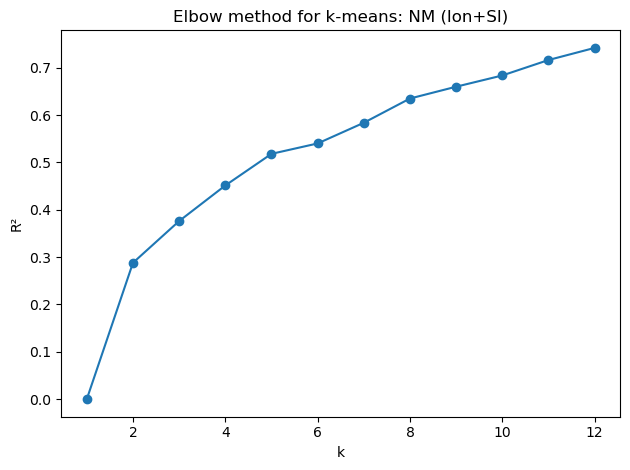

  k=2, silhouette score=0.364
  k=3, silhouette score=0.373
  k=4, silhouette score=0.378
  k=5, silhouette score=0.288
  k=6, silhouette score=0.206
  k=7, silhouette score=0.219
  k=8, silhouette score=0.334
  k=9, silhouette score=0.203
  k=10, silhouette score=0.286
  k=11, silhouette score=0.263
  k=12, silhouette score=0.343


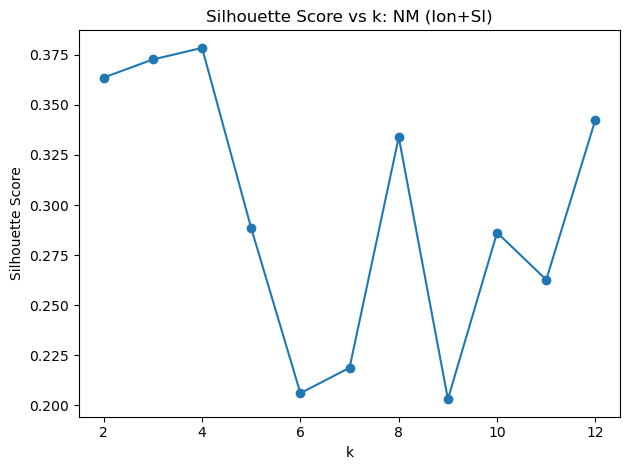


--- State: TX, Shape: (1836, 12) ---

--- State: TX ---


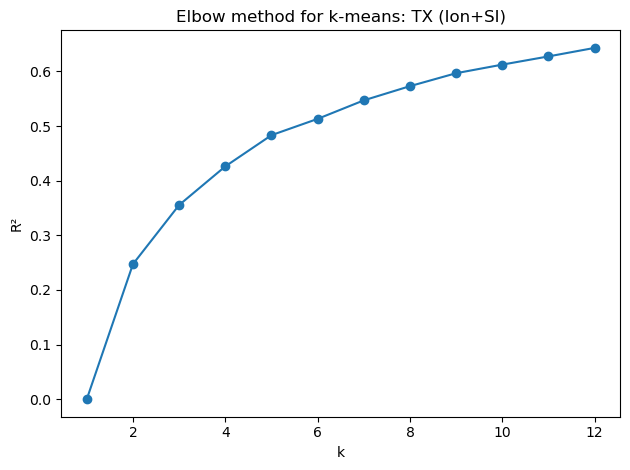

  k=2, silhouette score=0.258
  k=3, silhouette score=0.230
  k=4, silhouette score=0.229
  k=5, silhouette score=0.226
  k=6, silhouette score=0.198
  k=7, silhouette score=0.198
  k=8, silhouette score=0.196
  k=9, silhouette score=0.174
  k=10, silhouette score=0.171
  k=11, silhouette score=0.169
  k=12, silhouette score=0.171


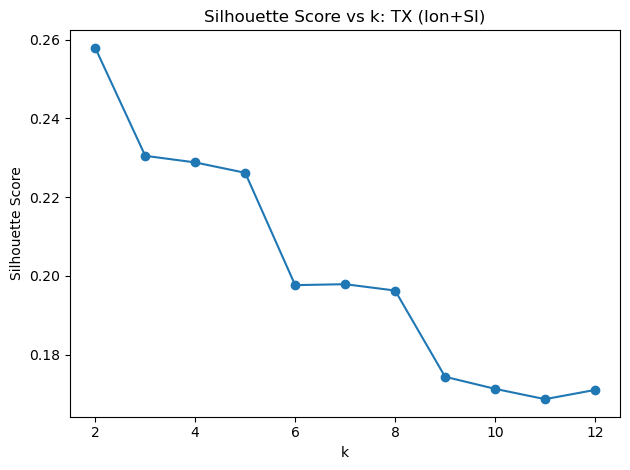


--- State: FL, Shape: (68, 12) ---

--- State: FL ---


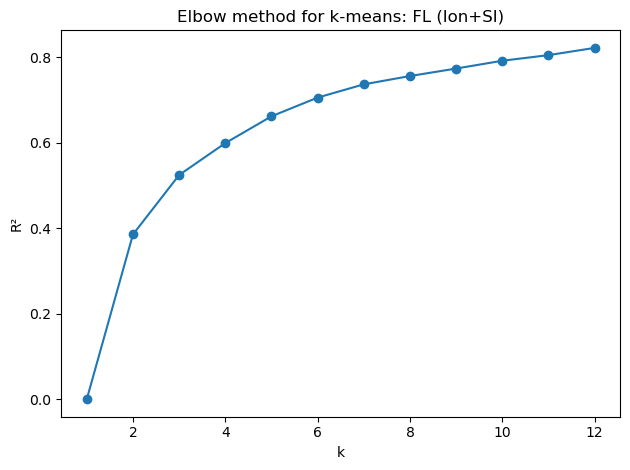

  k=2, silhouette score=0.415
  k=3, silhouette score=0.351
  k=4, silhouette score=0.331
  k=5, silhouette score=0.297
  k=6, silhouette score=0.298
  k=7, silhouette score=0.297
  k=8, silhouette score=0.270
  k=9, silhouette score=0.265
  k=10, silhouette score=0.266
  k=11, silhouette score=0.217
  k=12, silhouette score=0.224


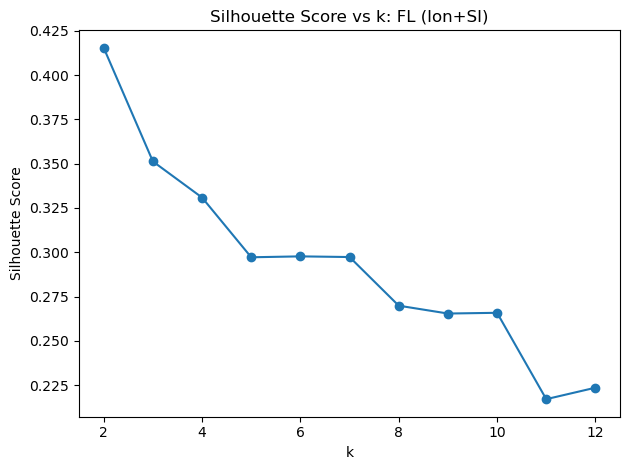


--- State: CA, Shape: (567, 12) ---

--- State: CA ---


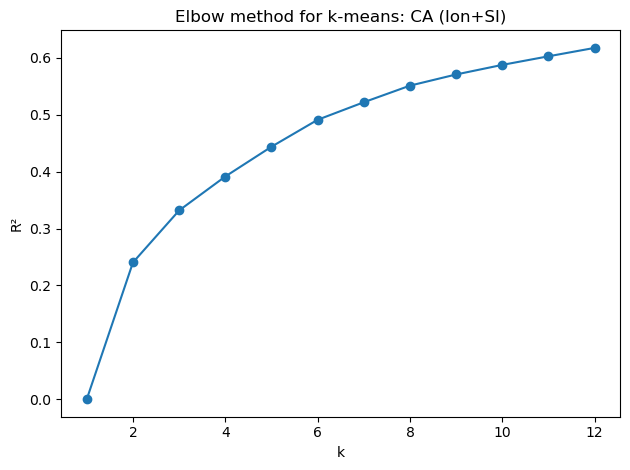

  k=2, silhouette score=0.245
  k=3, silhouette score=0.199
  k=4, silhouette score=0.203
  k=5, silhouette score=0.215
  k=6, silhouette score=0.215
  k=7, silhouette score=0.188
  k=8, silhouette score=0.193
  k=9, silhouette score=0.192
  k=10, silhouette score=0.183
  k=11, silhouette score=0.168
  k=12, silhouette score=0.181


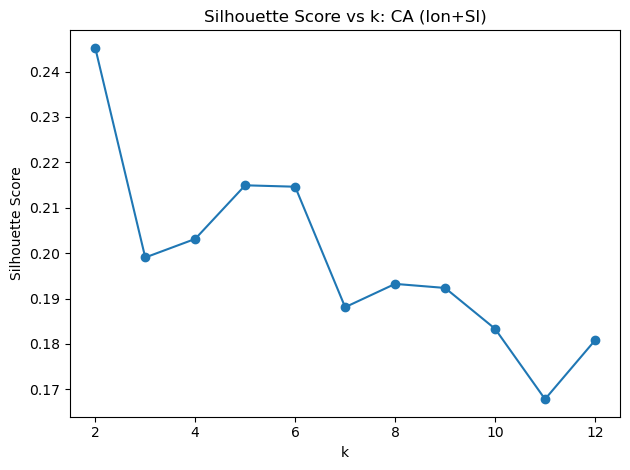


--- State: AZ, Shape: (266, 12) ---

--- State: AZ ---


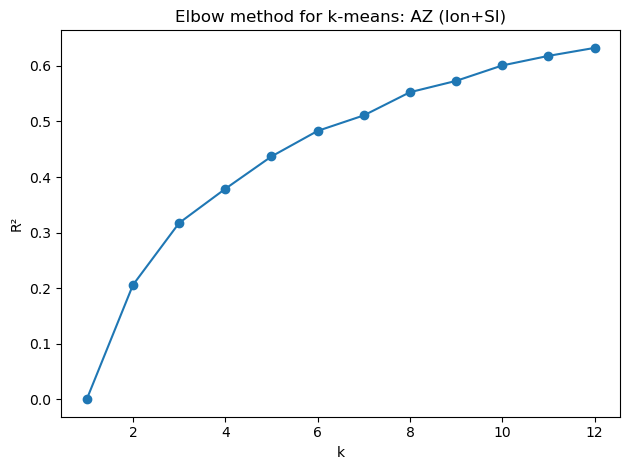

  k=2, silhouette score=0.207
  k=3, silhouette score=0.189
  k=4, silhouette score=0.156
  k=5, silhouette score=0.170
  k=6, silhouette score=0.168
  k=7, silhouette score=0.171
  k=8, silhouette score=0.192
  k=9, silhouette score=0.171
  k=10, silhouette score=0.181
  k=11, silhouette score=0.181
  k=12, silhouette score=0.178


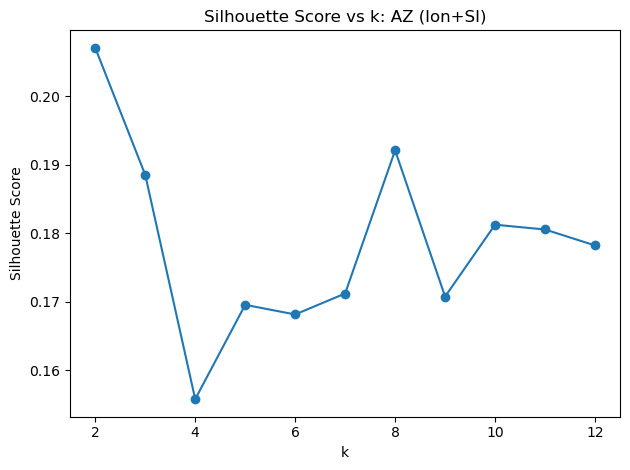

In [47]:
############### ION + PP CLUSTERING BY STATE PART 1 ###############

for state in states:
    # Prepare data for this state
    df_state = df[df[state_col] == state][ion_si_cols].replace([np.inf, -np.inf], np.nan).dropna()

    print(f"\n--- State: {state}, Shape: {df_state.shape} ---")

    print(f"\n--- State: {state} ---")
    if len(df_state) < 10:
        print(f"  Not enough samples, skipping.")
        continue

    X = df_state.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ----- 1. Elbow method (R²) -----
    r2_values = []
    k_max = min(12, len(X_scaled)-1)
    elbow_k_range = range(1, k_max+1)
    tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)
    for k in elbow_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X_scaled)
        between_ss = tot_ss - km.inertia_
        r2_values.append(between_ss / tot_ss)

    plt.figure()
    plt.plot(list(elbow_k_range), r2_values, marker='o')
    plt.xlabel('k')
    plt.ylabel('R²')
    plt.title(f'Elbow method for k-means: {state} (Ion+SI)')
    plt.tight_layout()
    plt.show()

    # ----- 2. Silhouette method -----
    sil_scores = []
    sil_k_range = range(2, min(13, len(X_scaled)))
    for k in sil_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        print(f"  k={k}, silhouette score={score:.3f}")

    plt.figure()
    plt.plot(list(sil_k_range), sil_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs k: {state} (Ion+SI)')
    plt.tight_layout()
    plt.show()





--- State: NM, Shape: (163, 24) ---


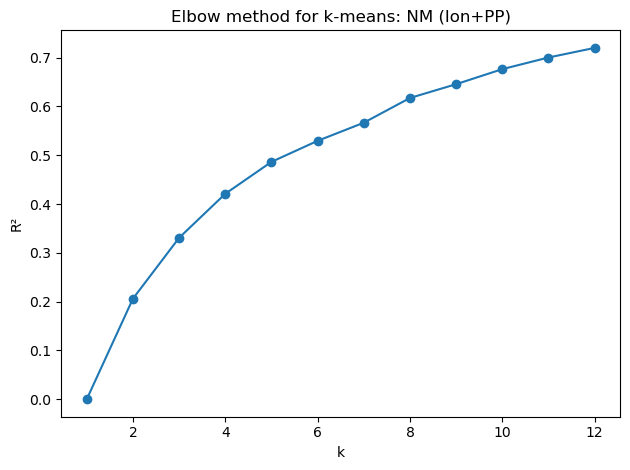

  k=2, silhouette score=0.306
  k=3, silhouette score=0.268
  k=4, silhouette score=0.293
  k=5, silhouette score=0.304
  k=6, silhouette score=0.328
  k=7, silhouette score=0.299
  k=8, silhouette score=0.288
  k=9, silhouette score=0.315
  k=10, silhouette score=0.221
  k=11, silhouette score=0.251
  k=12, silhouette score=0.262


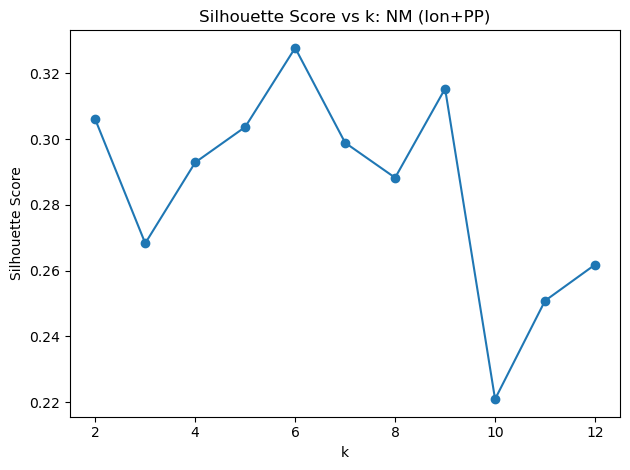


--- State: TX, Shape: (2384, 24) ---


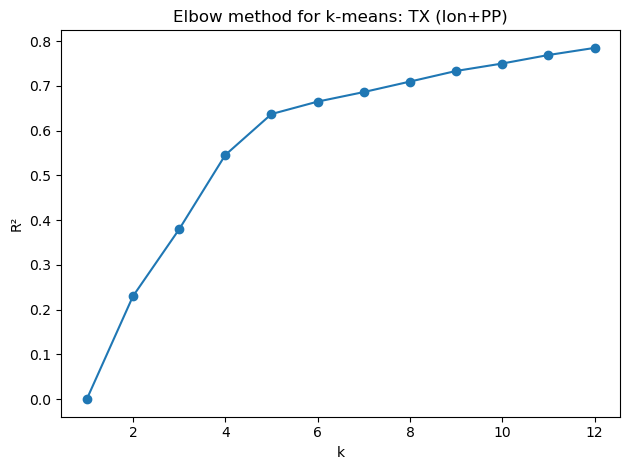

  k=2, silhouette score=0.322
  k=3, silhouette score=0.353
  k=4, silhouette score=0.357
  k=5, silhouette score=0.379
  k=6, silhouette score=0.365
  k=7, silhouette score=0.249
  k=8, silhouette score=0.253
  k=9, silhouette score=0.240
  k=10, silhouette score=0.236
  k=11, silhouette score=0.226
  k=12, silhouette score=0.222


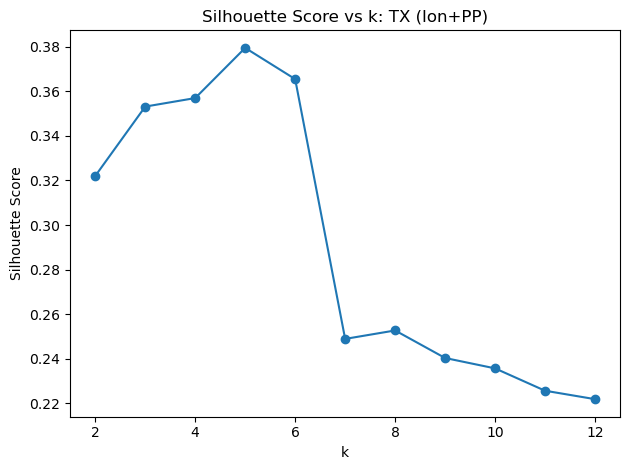


--- State: FL, Shape: (385, 24) ---


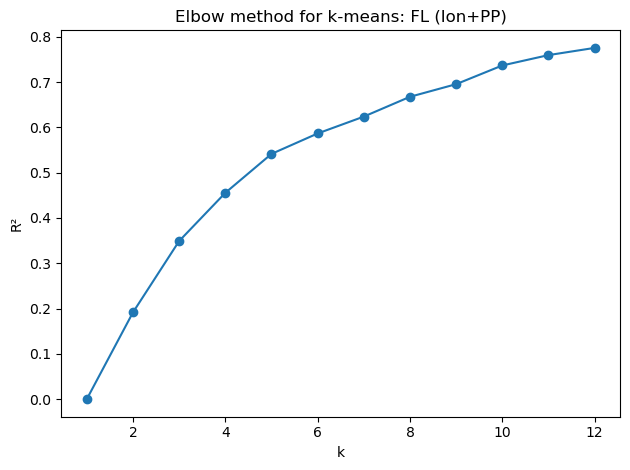

  k=2, silhouette score=0.374
  k=3, silhouette score=0.391
  k=4, silhouette score=0.419
  k=5, silhouette score=0.424
  k=6, silhouette score=0.423
  k=7, silhouette score=0.323
  k=8, silhouette score=0.318
  k=9, silhouette score=0.336
  k=10, silhouette score=0.342
  k=11, silhouette score=0.342
  k=12, silhouette score=0.327


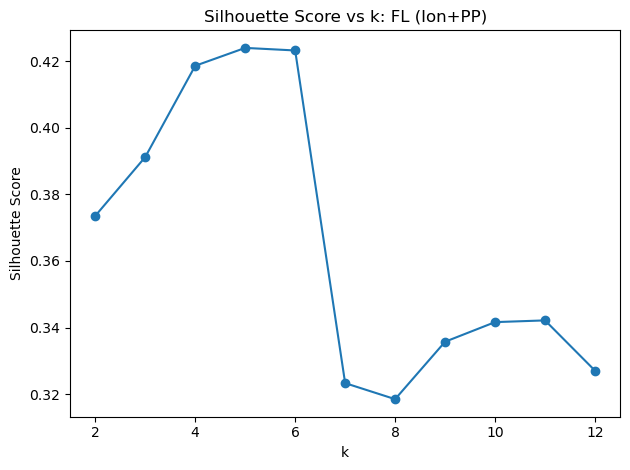


--- State: CA, Shape: (1267, 24) ---


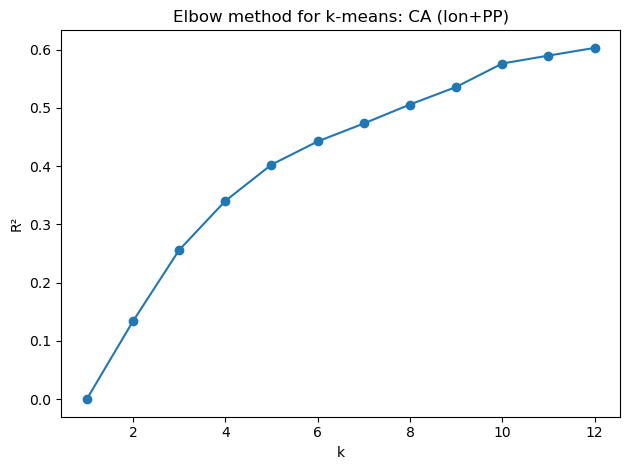

  k=2, silhouette score=0.183
  k=3, silhouette score=0.216
  k=4, silhouette score=0.223
  k=5, silhouette score=0.208
  k=6, silhouette score=0.211
  k=7, silhouette score=0.211
  k=8, silhouette score=0.187
  k=9, silhouette score=0.187
  k=10, silhouette score=0.220
  k=11, silhouette score=0.188
  k=12, silhouette score=0.171


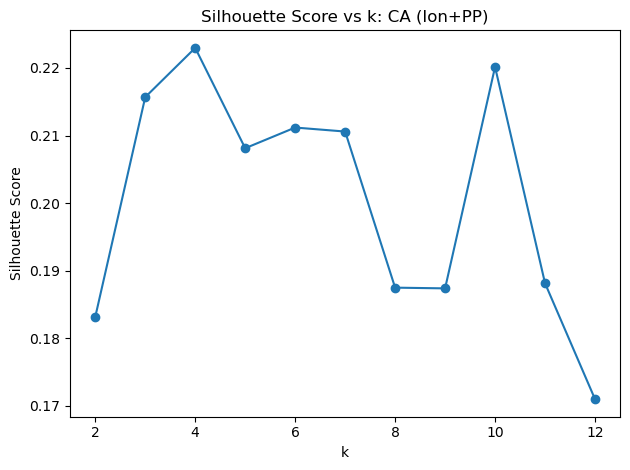


--- State: AZ, Shape: (605, 24) ---


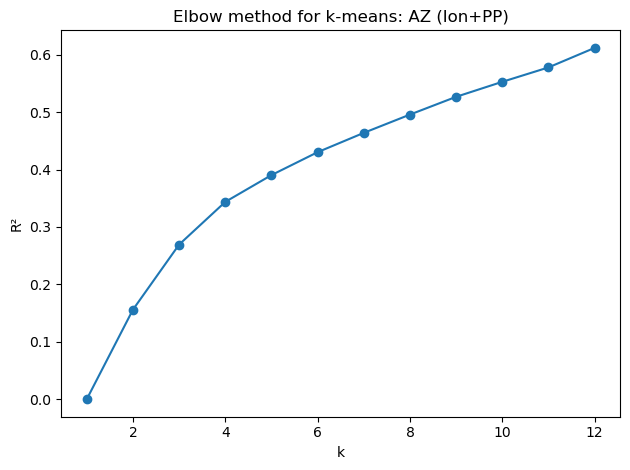

  k=2, silhouette score=0.373
  k=3, silhouette score=0.191
  k=4, silhouette score=0.198
  k=5, silhouette score=0.177
  k=6, silhouette score=0.180
  k=7, silhouette score=0.183
  k=8, silhouette score=0.178
  k=9, silhouette score=0.164
  k=10, silhouette score=0.182
  k=11, silhouette score=0.169
  k=12, silhouette score=0.174


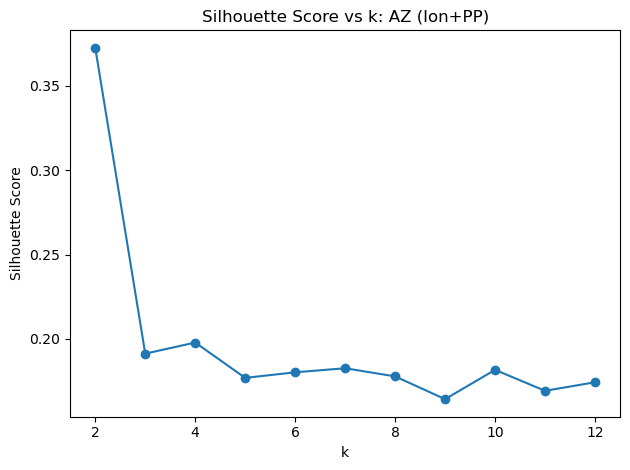

In [48]:
########## ION + PP CLUSTERING BY STATE ##########
pp_cols = [
    "model_pp_Calcite_open_2x", "model_pp_Calcite_open_4x", "model_pp_Calcite_open_8x", "model_pp_Calcite_open_16x",
    "model_pp_Chalcedony_open_2x", "model_pp_Chalcedony_open_4x", "model_pp_Chalcedony_open_8x", "model_pp_Chalcedony_open_16x",
    "model_pp_Gypsum_open_2x", "model_pp_Gypsum_open_4x", "model_pp_Gypsum_open_8x", "model_pp_Gypsum_open_16x",
    "model_pp_Barite_open_2x", "model_pp_Barite_open_4x", "model_pp_Barite_open_8x", "model_pp_Barite_open_16x"
]

# Combine ion and pp columns
ion_pp_cols = ion_cols + pp_cols

for state in states:
    df_state = df[df[state_col] == state][ion_pp_cols].replace([np.inf, -np.inf], np.nan).dropna()

    print(f"\n--- State: {state}, Shape: {df_state.shape} ---")
    if len(df_state) < 10:
        print(f"  Not enough samples, skipping.")
        continue

    X = df_state.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Elbow method (R²)
    r2_values = []
    k_max = min(12, len(X_scaled)-1)
    elbow_k_range = range(1, k_max+1)
    tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)
    for k in elbow_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X_scaled)
        between_ss = tot_ss - km.inertia_
        r2_values.append(between_ss / tot_ss)

    plt.figure()
    plt.plot(list(elbow_k_range), r2_values, marker='o')
    plt.xlabel('k')
    plt.ylabel('R²')
    plt.title(f'Elbow method for k-means: {state} (Ion+PP)')
    plt.tight_layout()
    plt.show()

    # Silhouette method
    sil_scores = []
    sil_k_range = range(2, min(13, len(X_scaled)))
    for k in sil_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        print(f"  k={k}, silhouette score={score:.3f}")

    plt.figure()
    plt.plot(list(sil_k_range), sil_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs k: {state} (Ion+PP)')
    plt.tight_layout()
    plt.show()



In [49]:
############### ION + PP CLUSTERING BY STATE PART 2 ###############

output_folder = "ion_pp"

state_k_map = {
    'NM': 6,
    'TX': 5,
    'FL': 5,
    'CA': 5,
    'AZ': 4
}

for state, k_state in state_k_map.items():
    print(f"\n--- Processing {state} (k={k_state}) ---")
    df_state = df[df[state_col] == state][ion_pp_cols].replace([np.inf, -np.inf], np.nan).dropna()
    if len(df_state) < k_state:
        print(f"  Not enough samples for k={k_state}, skipping.")
        continue
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_state)

    # Cluster assignment
    km = KMeans(n_clusters=k_state, random_state=42, n_init=10)
    cluster_labels = km.fit_predict(X_scaled)
    df_plot = df_state.copy()
    df_plot['Cluster'] = cluster_labels.astype(str)

    # Multi-panel boxplots of features by cluster
    n_features = len(ion_pp_cols)
    n_cols = 3
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    for idx, feature in enumerate(ion_pp_cols):
        ax = axes[idx]
        sns.boxplot(x='Cluster', y=feature, data=df_plot, ax=ax)
        ax.set_title(f"{feature} by Cluster")
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Boxplots_by_Cluster_{state}.png"), dpi=300)
    plt.close(fig)
    print(f"  Boxplots saved at: {output_folder}/Boxplots_by_Cluster_{state}.png")

    # PCA plot
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_plot['Cluster'], palette='Set1', s=30)
    plt.title(f'PCA of Clusters ({state}, Ion+PP)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"PCA_Clusters_{state}.png"), dpi=300)
    plt.close()
    print(f"  PCA plot saved at: {output_folder}/PCA_Clusters_{state}.png")




--- Processing NM (k=6) ---
  Boxplots saved at: ion_pp/Boxplots_by_Cluster_NM.png
  PCA plot saved at: ion_pp/PCA_Clusters_NM.png

--- Processing TX (k=5) ---
  Boxplots saved at: ion_pp/Boxplots_by_Cluster_TX.png
  PCA plot saved at: ion_pp/PCA_Clusters_TX.png

--- Processing FL (k=5) ---
  Boxplots saved at: ion_pp/Boxplots_by_Cluster_FL.png
  PCA plot saved at: ion_pp/PCA_Clusters_FL.png

--- Processing CA (k=5) ---
  Boxplots saved at: ion_pp/Boxplots_by_Cluster_CA.png
  PCA plot saved at: ion_pp/PCA_Clusters_CA.png

--- Processing AZ (k=4) ---
  Boxplots saved at: ion_pp/Boxplots_by_Cluster_AZ.png
  PCA plot saved at: ion_pp/PCA_Clusters_AZ.png
